In [ ]:
#!pip install beir

# Introduction

The goal of this project is to develop an effective search system in **IR** that retrieves the most relevant documents from a given corpus based on user queries. 
The dataset consists of:
1. A set of queries representing user search intents.
2. A collection of documents containing relevant information.
3. Relevance judgments, which indicate how relevant each document is to a given query according to expert assessments.

The system's objective is to accurately retrieve the most relevant documents from the corpus for a given query. By comparing our system’s results to the expert-provided relevance judgments, we can evaluate its performance and assess its ability to deliver high-quality search results.


In [ ]:
# === BEIR Library Imports ===
# Used for loading datasets, building retrieval models, and evaluating retrieval performance.
from beir import util, LoggingHandler
from beir.retrieval import models
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES

# === PyTerrier Initialization ===
# PyTerrier is used for building and evaluating information retrieval pipelines.
import pyterrier as pt
from pyterrier.measures import *
if not pt.started():
    pt.init(tqdm='notebook')  # Initialize PyTerrier with notebook-friendly progress bars.

# === Gensim for Word Embeddings ===
# Gensim is used to load pre-trained word embeddings like GloVe.
from gensim import downloader
from gensim.models import Word2Vec

# === Standard Library Imports ===
# Utility libraries for file handling, logging, and other general-purpose tasks.
import logging
import pathlib
import os

# === Data Handling and Text Processing ===
# Libraries for data manipulation (pandas) and text processing (regex).
import pandas as pd
import re

# === Natural Language Toolkit (NLTK) ===
# NLTK is used for tokenization and other NLP preprocessing tasks.
import nltk
nltk.download('punkt')  # Download necessary tokenizer models.

# Load pre-trained GloVe word embeddings (via Gensim's downloader).
wiki_model = downloader.load('glove-wiki-gigaword-100')

# === Transformers and PyTorch ===
# Hugging Face Transformers for using pre-trained language models.
# PyTorch for tensor operations and model execution.
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# === TQDM for Progress Bars ===
# TQDM provides visual feedback on the progress of loops and tasks.
from tqdm import tqdm

# === Visualization Libraries ===
# Libraries for data visualization (Matplotlib and Seaborn).
import matplotlib.pyplot as plt
import seaborn as sns

# === ONIR ===
# Onir is used for integration with PyTerrier, typically in certain retrieval setups.
import onir_pt


/tmp/ipykernel_5251/1946495959.py:13: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():
[nltk_data] Downloading package punkt to /home/joshua/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2025-01-25 21:47:32 - loading projection weights from /home/joshua/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz


## Utility Functions

### 1. `evaluate_and_visualize`
Evaluates the BM25 and TF-IDF models based on a set of queries and relevance judgments (qrels), then visualizes the **evaluation metrics** (AP@1000, P@5, P@10) -  to compare the performance of both models.
    1.AP@1000 (Average Precision at 1000) – Measures how well the model ranks relevant documents.
    2.P@5 (Precision at 5) – Checks how many of the top 5 retrieved documents are relevant.
    3.P@10 (Precision at 10) – Similar but for the top 10 results

### 2. `plot_model_results`
Creates a bar plot to visualize the evaluation metrics for both the BM25 and TF-IDF models, comparing their performance across different metrics( (AP@1000, P@5, P@10).

### 3. `plot_experiment_results`
Generates line plots that visualize how different query-processing techniques impact the retrieval effectiveness of BM25 and TF-IDF models.

### 4. `clean_query`
Cleans a query by removing non-alphanumeric characters (except whitespace) f.e.:
clean_query("What is the impact of cholesterol on heart disease??? :) ")
Output: "What is the impact of cholesterol on heart disease"

in addition ensures that the query is not empty after cleaning. If the query becomes empty, it returns "Invalid query".

### 5. `add_sym`
Enhances a query by adding symbols (e.g., "+" and weights) to terms in the query based on their frequency in the lexicon. Words with lower frequencies are assigned a "+" symbol and a weight f.e.:
add_sym("heart attack risk")
Output: "+heart +attack risk"

The words "heart" and "attack" are rare in the dataset, so they are boosted with +  -> Improves ranking by emphasizing important terms.
"risk" is more common, so it remains unchanged ->Mimics human intuition (rare terms usually carry more meaning in searches).

### 6. `emb_add`
Enhances a query by adding similar words based on the wiki embedding model. It adds words with a similarity above a threshold (0.7) to the original query.

Finds top similar words (with a similarity score above 0.7).
Appends them to the original query, that expands the search space and may retrieving more relevance documents. 

### 7. `remove_terms`
Removes high-frequency terms (those with a frequency greater than 10,000) from a query by checking the frequency of each term in the lexicon.
Improves precision by eliminating stopwords that don’t contribute to document ranking f.e. words like the,is,are and so on....

In [87]:
def evaluate_and_visualize(queries, qrels_df, bm25, tfidf, metrics=[AP@1000, P@5, P@10]):
    """
    Evaluates BM25 and TF-IDF models on a set of queries and relevance judgments (qrels),
    and visualizes the evaluation metrics.

    Args:
    queries (pd.DataFrame): DataFrame containing queries to transform.
    qrels_df (pd.DataFrame): DataFrame containing relevance judgments with columns ['qid', 'docno', 'label'].
    bm25: PyTerrier BM25 retrieval model.
    tfidf: PyTerrier TF-IDF retrieval model.
    """

    # Models dictionary
    models = {
        "BM25": bm25,
        "TF-IDF": tfidf
    }

    results = {}
    
    for model_name, model in models.items():
        # Transform queries using the model
        run_results = model.transform(queries)
        
        # Find common 'qid' values between qrels and model run results
        qrel_ids = set(qrels_df['qid'])
        run_ids = set(run_results['qid'])
        common_ids = qrel_ids.intersection(run_ids)
        print(f"{model_name}: {len(common_ids)} common qids found.")
        
        # Filter qrels and run results based on common qids
        filtered_qrels = qrels_df[qrels_df['qid'].isin(common_ids)]
        filtered_run_results = run_results[run_results['qid'].isin(common_ids)]
        
        # Evaluate the model
        evaluation_results = pt.Evaluate(
            filtered_run_results,
            filtered_qrels,
            metrics=metrics
        )
        
        # Store the results
        results[model_name] = evaluation_results

    return results

def plot_model_results(evaluation_results):
    """
    Plots evaluation metrics for BM25 and TF-IDF models.

    Args:
    evaluation_results (dict): A dictionary of evaluation results for each model.
    """
    # Convert results into a DataFrame
    df = pd.DataFrame(evaluation_results).T.reset_index()
    df = df.rename(columns={"index": "Model"})
    
    # Melt the DataFrame for plotting
    melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted, x='Metric', y='Score', hue='Model', palette='Set2')
    plt.title("Model Performance Comparison")
    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.show()

def plot_experiment_results(results, metrics):
    """
    Plots results of experiments for BM25 and TF-IDF models.

    Args:
    results (list): Results from experiments.
    metrics (list): List of metrics used for evaluation.
    """
    # Prepare data for plotting
    bm25_scores = {metric: [] for metric in metrics}
    tfidf_scores = {metric: [] for metric in metrics}
    experiment_names = [result["experiment"] for result in results]

    for result in results:
        for metric in metrics:
            bm25_scores[metric].append(result["bm25"][metric])
            tfidf_scores[metric].append(result["tfidf"][metric])

    # Plot the results
    fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5), sharey=True)
    for i, metric in enumerate(metrics):
        axes[i].plot(experiment_names, bm25_scores[metric], label="BM25", marker='o')
        axes[i].plot(experiment_names, tfidf_scores[metric], label="TF-IDF", marker='o')
        axes[i].set_title(metric)
        axes[i].set_xlabel("Experiment")
        axes[i].set_ylabel("Score")

        # Adjust x-axis ticks to prevent overlap
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_xticks(range(len(experiment_names)))
        axes[i].set_xticklabels(experiment_names, rotation=45, ha="right")

        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Function to clean a query by removing non-alphanumeric characters and handling empty queries
def clean_query(query):
    """
    This function cleans a query by removing non-alphanumeric characters (except whitespace).
    If the query becomes empty after cleaning, it returns "Invalid query".
    
    Args:
    query (str): The query string to be cleaned.
    
    Returns:
    str: The cleaned query or "Invalid query" if the query is empty.
    """
    # Remove non-alphanumeric characters (except spaces)
    query = re.sub(r'[^\w\s]', '', query)
    
    # If the query becomes empty after cleaning, return "Invalid query"
    if len(query.strip()) == 0:
        return "Invalid query"
    return query

# Function to add symbols to terms based on frequency in the lexicon
def add_sym(text):
    """
    This function adds symbols (e.g., "+" and weights) to terms in a query based on their frequency
    in the lexicon. Words with lower frequencies (< 150) are given a "+" symbol and a weight.
    
    Args:
    text (str): The input query to be processed.
    
    Returns:
    str: The processed query with added symbols and deduplicated terms.
    """
    # Tokenize the input text
    tokens = text.split()
    new = []
    
    # Iterate over each token (word)
    for word in tokens:
        # Check if the word exists in the lexicon
        if word in index.getLexicon():
            # If word frequency is <= 150, add "+" symbol and a weight
            if index.getLexicon()[word].getFrequency() <= 150:
                new.append('+'+word+'^10.3')
            else:
                new.append(word)
    
    # Remove duplicate terms
    new = list(set(new))

    # Join the terms to form the final query string
    output = ' '.join(new)
    
    # If the query is empty, print a warning and return the original text
    if not output:
        # print(f"Warning: add_sym produced an empty query for input: '{text}'")
        output = text
    
    return output

# Function to enhance queries by adding similar words based on an embedding model
def emb_add(text):
    """
    This function enhances a query by adding similar words based on the wiki embedding model.
    It checks if a word exists in the lexicon and, if so, finds the top 3 most similar words
    to it based on embedding similarity (only adding words with a similarity above 0.7).
    
    Args:
    text (str): The input query to be processed.
    
    Returns:
    str: The enhanced query with added similar words and deduplicated terms.
    """
    # Tokenize the input text
    tokens = text.split()
    # print(f"Processing query: '{text}'")
    new = []  # To hold the final query terms
    
    # Iterate over each word in the query
    for word in tokens:
        # If the word is in the lexicon, find similar words
        if word in index.getLexicon():
            # print(f"Word '{word}' is in the lexicon.")
            new.append(word)
            
            try:
                # Find top 3 most similar words using the wiki embedding model
                result = wiki_model.most_similar(word, topn=3)
                for similar_word, similarity in result:
                    # If similarity is above threshold, add similar word to the query
                    if similarity >= 0.7:
                        new.append(similar_word)
            except Exception as e:
                # print(f"Error finding similar word for '{word}': {e}")
                pass
        else:
            # If word is not in lexicon, add it as-is
            # print(f"Word '{word}' is NOT in the lexicon. Adding it as-is.")
            new.append(word)
    
    # Remove duplicate terms
    new = list(set(new))
    
    # Join the terms into a final query string
    output = ' '.join(new)
    
    # If the query is empty, print a warning and return the original text
    if not output:
        # print(f"Warning: emb_add produced an empty query for input: '{text}'")
        output = text
    
    return output

# Function to remove high-frequency terms from the query
def remove_terms(text):
    """
    This function removes high-frequency terms (those with a frequency > 10,000) from a query.
    The function checks if a word exists in the lexicon, and if its frequency is too high, it is removed.
    
    Args:
    text (str): The input query to be processed.
    
    Returns:
    str: The query with high-frequency terms removed and deduplicated terms.
    """
    tokens = text.split()
    new = []
    
    # Iterate over tokens and remove high-frequency words
    for word in tokens:
        if word in index.getLexicon():
            if index.getLexicon()[word].getFrequency() > 10000:
                new.append('')  # Remove word if frequency is too high
            else:
                new.append(word)
    
    # Remove duplicates
    new = list(set(new))

    # Join the terms into a final query string
    output = ' '.join(new)
    
    # If the query is empty, print a warning and return the original text
    if not output:
        # print(f"Warning: remove_terms produced an empty query for input: '{text}'")
        output = text
    
    return output

# Data Cleaning Process

To prepare the dataset for efficient processing, a comprehensive data cleaning process was performed:

1. **Corpus Conversion**: The corpus dictionary was converted into a structured DataFrame to enable easier manipulation and analysis.

2. **Standardization**: The `title` and `text` columns were converted to lowercase to ensure uniformity and eliminate case-related inconsistencies.

3. **Removal of Non-Alphanumeric Characters**: A custom cleaning function was applied to remove non-alphanumeric characters, except for whitespace, from the `title` and `text` columns. This step helps maintain clean and meaningful textual data.

4. **Handling Empty or Invalid Queries**: The cleaning function checked for and handled empty or invalid queries, replacing them with an appropriate placeholder value (e.g., "Invalid query").

These steps ensured that the data was consistent, clean, and ready for further analysis and processing.

In [88]:
# Set up logging to print debug information with timestamps
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

# Download and unzip the NFCorpus dataset
dataset = "nfcorpus"
url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
out_dir = os.path.join(pathlib.Path('./').parent.absolute(), "datasets")
data_path = util.download_and_unzip(url, out_dir)

# Load the NFCorpus dataset (corpus, queries, qrels) for the test split
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

2025-01-25 21:06:23 - Loading Corpus...


  0%|          | 0/3633 [00:00<?, ?it/s]

2025-01-25 21:06:23 - Loaded 3633 TEST Documents.
2025-01-25 21:06:23 - Doc Example: {'text': 'Recent studies have suggested that statins, an established drug group in the prevention of cardiovascular mortality, could delay or prevent breast cancer recurrence but the effect on disease-specific mortality remains unclear. We evaluated risk of breast cancer death among statin users in a population-based cohort of breast cancer patients. The study cohort included all newly diagnosed breast cancer patients in Finland during 1995–2003 (31,236 cases), identified from the Finnish Cancer Registry. Information on statin use before and after the diagnosis was obtained from a national prescription database. We used the Cox proportional hazards regression method to estimate mortality among statin users with statin use as time-dependent variable. A total of 4,151 participants had used statins. During the median follow-up of 3.25 years after the diagnosis (range 0.08–9.0 years) 6,011 participants die

In [89]:
# Convert corpus dictionary to a DataFrame
data = pd.DataFrame.from_dict(corpus, orient='index')
data['docno'] = data.index  # Create a 'docno' column with the index values
data.reset_index(drop=True, inplace=True)  # Reset the index of the DataFrame

# Convert "title" and "text" columns to lowercase if they exist
if 'title' in data.columns:
    data['title'] = data['title'].str.lower()
if 'text' in data.columns:
    data['text'] = data['text'].str.lower()

# Function to clean queries
def clean_query(query):
    query = re.sub(r'EOF', '', query)  # Remove the string "EOF" (case-sensitive)
    query = re.sub(r'[^\w\s]', '', query)  # Remove non-alphanumeric characters except whitespace
    query = query.strip()  # Remove leading/trailing whitespace
    
    if not query:  # Check for empty or invalid queries
        return "Invalid query"
    return query

# Apply cleaning to "title" and "text" columns
if 'title' in data.columns:
    data['title'] = data['title'].apply(clean_query)
if 'text' in data.columns:
    data['text'] = data['text'].apply(clean_query)

# Display the updated DataFrame
data.head()

,text,title,docno
0,recent studies have suggested that statins an ...,statin use and breast cancer survival a nation...,MED-10
1,background preclinical studies have shown that...,statin use after diagnosis of breast cancer an...,MED-14
2,the aims of this study were to determine the c...,alkylphenols in human milk and their relations...,MED-118
3,epilepsy or seizure disorder is one of the mos...,methylmercury a potential environmental risk f...,MED-301
4,hit reaction time latencies hrt in the continu...,sensitivity of continuous performance test cpt...,MED-306


In [90]:
# Convert queries dictionary to a DataFrame
queries = pd.DataFrame.from_dict(queries, orient='index', columns=['query'])

# Create a 'qid' column from the DataFrame index
queries['qid'] = queries.index

# Reset the index of the DataFrame and drop the old index
queries.reset_index(drop=True, inplace=True)

# Convert 'query' column to lowercase if it exists
if 'query' in queries.columns:
    queries['query'] = queries['query'].str.lower()

# Display a sample of 20 rows from the queries DataFrame
queries.sample(20)

,query,qid
202,tempeh,PLAIN-2220
101,ergothioneine,PLAIN-1130
221,preventing brain loss with b vitamins?,PLAIN-2430
304,are multivitamins good for you?,PLAIN-3292
197,subsidies,PLAIN-2167
315,antioxidant content of 300 foods,PLAIN-3402
41,is vitamin d3 (cholecalciferol) preferable to ...,PLAIN-468
228,the saturated fat studies: buttering up the pu...,PLAIN-2500
51,anisakis,PLAIN-571
307,veggies vs. cancer,PLAIN-3322


In [91]:
len(queries)

323

In [92]:
empty_query_count = queries['query'].isna().sum() + (queries['query'] == '').sum()
print(f"Number of empty queries: {empty_query_count}")

Number of empty queries: 0


In [93]:
# Assuming 'queries' is the DataFrame you provided and contains a column 'query'
query_row = queries[queries['qid'].str.contains('PLAIN-2', case=False, na=False)]

# Display the row containing 'PLAIN-2'
query_row

,query,qid
0,do cholesterol statin drugs cause breast cancer?,PLAIN-2
2,how to reduce exposure to alkylphenols through...,PLAIN-23
19,avoiding cooked meat carcinogens,PLAIN-207
20,plant-based diets for psoriasis,PLAIN-217
21,increasing muscle strength with fenugreek,PLAIN-227
...,...,...
273,unsafe at any feed,PLAIN-2950
274,pharmacists versus health food store employees...,PLAIN-2960
275,preventing cataracts with diet,PLAIN-2970
276,cheese mites and maggots,PLAIN-2981


In [94]:
# Flatten the qrels dictionary into a list of dictionaries
# Each dictionary contains 'qid' (query id), 'docno' (document id), and 'relevance' (relevance score)
flat_qrels = [{'qid': query_id, 'docno': doc_id, 'relevance': relevance}
              for query_id, inner_dict in qrels.items()
              for doc_id, relevance in inner_dict.items()]

# Convert the list of dictionaries into a pandas DataFrame
qrels_df = pd.DataFrame(flat_qrels)

# Display a random sample of 20 rows from the qrels DataFrame
qrels_df.sample(20)

,qid,docno,relevance
6405,PLAIN-1667,MED-1457,1
6344,PLAIN-1667,MED-3450,1
10341,PLAIN-2560,MED-3954,1
5789,PLAIN-1601,MED-2646,1
3197,PLAIN-934,MED-1622,1
3624,PLAIN-1050,MED-1394,1
9884,PLAIN-2440,MED-5324,1
6121,PLAIN-1635,MED-3358,1
6255,PLAIN-1635,MED-4666,1
7215,PLAIN-1837,MED-1750,1


# PyTerrier Indexing Properties

The following global properties were set for the PyTerrier indexing process:

1. **Text Processing Pipeline**: 
   - **Stopword Removal**: The pipeline includes stopword removal to  common words (e.g., the, and, is, of), which do not add value in search.
   - **Stemming**: Applied **Porter stemming** to reduce words to their root forms, (e.g., running, runs, ran → run) , helps match different word forms

2. **Positional Indexing**: 
   - Enabled positional indexing to store term positions within documents. This allows for more advanced query handling, such as phrase searches.

3. **Document Compression**: 
   - Compression was enabled for document storage to optimize index size and improve retrieval efficiency.

Additionally, the dataset was converted into a dictionary format compatible with PyTerrier for indexing.

In [95]:
# Set global properties for PyTerrier indexing
# Specify the text processing pipeline: stopwords removal and stemming
pt.set_property("termpipelines", "Stopwords,PorterStemmer")
# Enable positional indexing to store term positions
pt.set_property("index.positions", "true")
# Enable compression for the document storage in the index
pt.set_property("index.compression.documents", "enabled")

/tmp/ipykernel_5251/2641843832.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) set_property. (use pt.terrier.set_property(...) instead) -- Deprecated since version 0.11.0.
  pt.set_property("termpipelines", "Stopwords,PorterStemmer")
/tmp/ipykernel_5251/2641843832.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) set_property. (use pt.terrier.set_property(...) instead) -- Deprecated since version 0.11.0.
  pt.set_property("index.positions", "true")
/tmp/ipykernel_5251/2641843832.py:7: DeprecationWarning: Call to deprecated function (or staticmethod) set_property. (use pt.terrier.set_property(...) instead) -- Deprecated since version 0.11.0.
  pt.set_property("index.compression.documents", "enabled")


In [ ]:
data_dict = data.to_dict(orient='records')
#data_dict   - optional to see the whole data.

# Multiple Indexing based on Fields to Index
In this experiment, we conducted multiple indexing tests to explore how indexing different fields might impact the performance of the IR system. We were curious to see the differences in retrieval effectiveness when varying the fields indexed. The following configurations were tested:

1. **First Index**: 
   - Indexed both `text` and `title` fields.

2. **Second Index**: 
   - Indexed only the `text` field.

3. **Third Index**: 
   - Indexed only the `title` field.

Collection statistics were printed for each index to assess retrieval performance based on these different configurations.

In [97]:
# Create the first indexer with stopword removal and stemming (text and title fields)
indexer1 = pt.IterDictIndexer(
    "./index1",           # Path to store the generated index
    stopwords='terrier',   # Use the 'terrier' stopword list for stopword removal
    stemmer='porter',      # Apply Porter stemming during indexing
    overwrite=True         # Overwrite the existing index if it already exists
)

# Index the documents by processing both text and title fields
# and including metadata fields (docno, text, and title).
index_ref1 = indexer1.index(
    data_dict,                      # Data source (documents to be indexed)
    fields=('text', 'title'),       # Fields to index (text and title)
    meta=('docno', 'text', 'title') # Metadata fields to store for each document
)

# Create the second indexer with only stopword removal (text field only)
indexer2 = pt.IterDictIndexer(
    "./index2",          # Path to store the generated index
    stopwords='terrier',  # Use the 'terrier' stopword list for stopword removal
    stemmer=None,         # No stemming applied in this indexer
    overwrite=True        # Overwrite the existing index if it already exists
)

# Index the documents by processing only the text field
# and including metadata fields (docno, text, and title).
index_ref2 = indexer2.index(
    data_dict,                      # Data source (documents to be indexed)
    fields=('text',),               # Field to index (text only)
    meta=('docno', 'text', 'title') # Metadata fields to store for each document
)

# Create the third indexer with only stemming applied (title field only)
indexer3 = pt.IterDictIndexer(
    "./index3",          # Path to store the generated index
    stopwords=None,       # No stopword removal applied
    stemmer='porter',     # Apply Porter stemming during indexing
    overwrite=True        # Overwrite the existing index if it already exists
)

# Index the documents by processing only the title field
# and including metadata fields (docno, text, and title).
index_ref3 = indexer3.index(
    data_dict,                      # Data source (documents to be indexed)
    fields=('title',),              # Field to index (title only)
    meta=('docno', 'text', 'title') # Metadata fields to store for each document
)

/home/joshua/.local/lib/python3.10/site-packages/pyterrier/terrier/index.py:624: UserWarning: Indexing meta key text length requested 512 but exceeded in first document (actual length 1658). Increase the length in the meta dict for the indexer, e.g., pt.IterDictIndexer(..., meta={'text': 1658}).
  warn(msg)


In [98]:
# Load the index created with text and title fields (index_ref)
index = pt.IndexFactory.of(index_ref1)

# Print the statistics of the collection in the loaded index
print(index.getCollectionStatistics().toString())

# Load the index created with only the text field (index_ref2)
index2 = pt.IndexFactory.of(index_ref2)

# Print the statistics of the collection in the loaded index
print(index2.getCollectionStatistics().toString())

# Load the index created with only the title field (index_ref3)
index3 = pt.IndexFactory.of(index_ref3)

# Print the statistics of the collection in the loaded index
print(index3.getCollectionStatistics().toString())

Number of documents: 3633
Number of terms: 25794
Number of postings: 324881
Number of fields: 2
Number of tokens: 524435
Field names: [text, title]
Positions:   false

Number of documents: 3633
Number of terms: 32526
Number of postings: 338551
Number of fields: 1
Number of tokens: 492356
Field names: [text]
Positions:   false

Number of documents: 3633
Number of terms: 5746
Number of postings: 43860
Number of fields: 1
Number of tokens: 46310
Field names: [title]
Positions:   false



## Index Performance Conclusion

### Index 1 (Best Results)
- **Precision@5**: above 30%
- **Reason**: Indexed both the `title` and `text` fields, providing more information and better retrieval performance.

### Index 2
- **Precision@5**: Lower than Index 1
- **Reason**: Indexed only the `text` field, offering less information than Index 1 but still performing better than Index 3.

### Index 3 (Lowest Results)
- **Precision@5**: The lowest
- **Reason**: Indexed only the `title` field, providing the least amount of information and resulting in the lowest performance.

BM25: 307 common qids found.
TF-IDF: 307 common qids found.
BM25: 297 common qids found.
TF-IDF: 297 common qids found.
BM25: 279 common qids found.
TF-IDF: 279 common qids found.


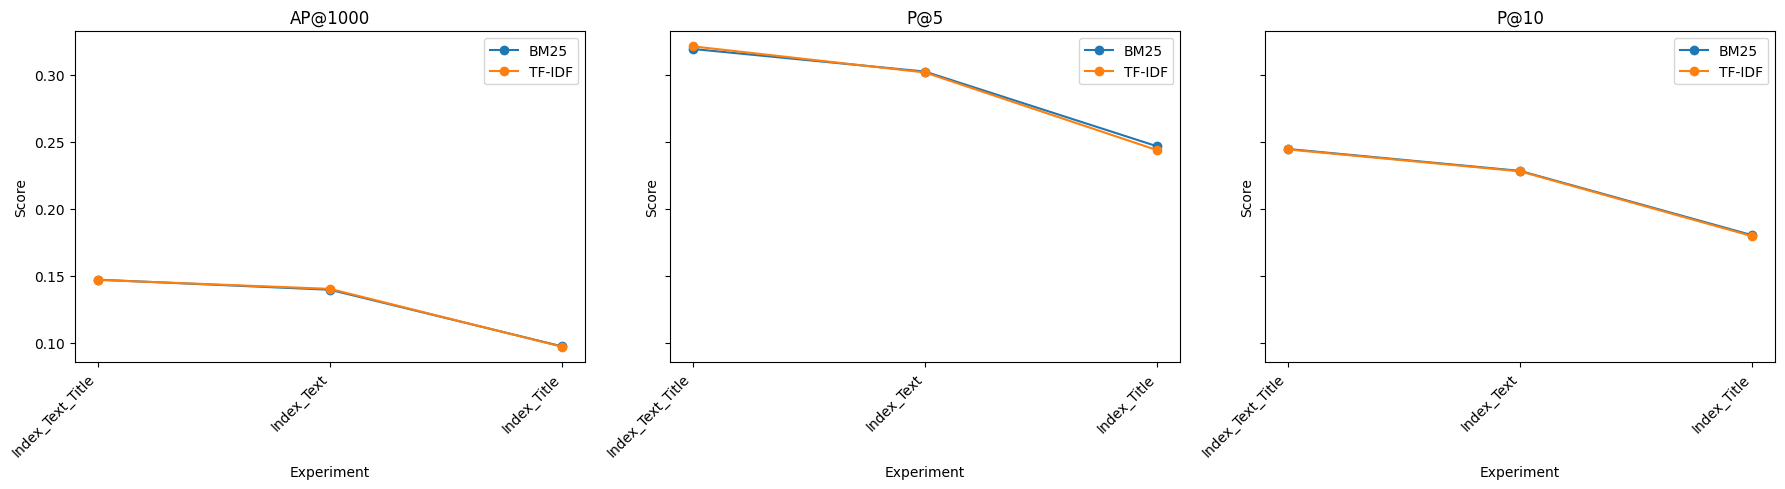

In [99]:
def evaluate_index_experiment(queries, qrels_df, index_refs, metrics=[AP@1000, P@5, P@10]):
    """
    Evaluates multiple indexes across different retrieval models (BM25 and TF-IDF).

    Args:
    queries (pd.DataFrame): DataFrame containing original queries.
    qrels_df (pd.DataFrame): DataFrame containing relevance judgments.
    index_refs (list): List of PyTerrier indexes to evaluate (e.g., [index_ref1, index_ref2, index_ref3]).
    metrics (list, optional): List of evaluation metrics. Defaults to ['AP@1000', 'P@5', 'P@10'].

    Returns:
    dict: Results containing scores for each index and metric.
    """
    results = []

    # Preprocess the queries by applying cleaning
    processed_queries = queries.copy()
    processed_queries['query'] = processed_queries['query'].apply(clean_query)

    index_names = ['Index_Text_Title', 'Index_Text', 'Index_Title']
    
    # Iterate through each index
    for index_name, index in zip(index_names, index_refs):
        # Create a BM25 retriever using the index
        bm25 = pt.terrier.Retriever(index, wmodel="BM25")
        
        # Create a TF-IDF retriever using the index
        tfidf = pt.terrier.Retriever(index, wmodel="TF_IDF")
        
        # Evaluate both BM25 and TF-IDF retrievers for the current index
        models_results = evaluate_and_visualize(processed_queries, qrels_df, bm25, tfidf, metrics)

        # Store results for each index
        results.append({
            "experiment": index_name,
            "bm25": models_results["BM25"],
            "tfidf": models_results["TF-IDF"]
        })

    # Return the results from all indexes
    return results

# Define the indexes to evaluate
index_refs = [index_ref1, index_ref2, index_ref3]

# Evaluate the indexes and visualize results
results = evaluate_index_experiment(queries, qrels_df, index_refs)
plot_experiment_results(results, metrics=['AP@1000', 'P@5', 'P@10'])

# Second Test: Evaluating Query Processing Approaches

In this second test, we chose to use **Index 1** (which indexed both `title` and `text`) as it showed the best performance in the first test. The objective of this experiment was to evaluate which query processing approach yields the best results.

### Experiment Approaches:
1. **Cleaning Only**
   - **Steps**: Clean the query by removing non-alphanumeric characters and handling empty queries.
   
2. **Cleaning + add_sym**
   - **Steps**: Clean the query and enhance terms by adding symbols based on frequency in the lexicon.
   
3. **Cleaning + emb_add**
   - **Steps**: Clean the query and enhance terms by adding similar words based on an embedding model.
   
4. **Cleaning + remove_terms**
   - **Steps**: Clean the query and remove high-frequency terms (those with a frequency greater than 10,000).

### Goal:
By applying these different combinations of query processing steps, we aim to determine which approach results in the best retrieval performance when applied to Index 1.

In [97]:
# Create a BM25 retriever using the index
bm25 = pt.terrier.Retriever(index, wmodel="BM25")

# Create a TF-IDF retriever using the index
tfidf = pt.terrier.Retriever(index, wmodel="TF_IDF")

## Conclusion:
The **Cleaning Only** approach provided the best result, achieving precision above 30%. The other steps introduced either unnecessary noise or removed too much useful information, leading to lower precision. The key takeaway is that simpler query cleaning often yields better results than more complex transformations, especially when working with a robust index like **Index 1**.

BM25: 307 common qids found.
TF-IDF: 307 common qids found.
BM25: 286 common qids found.
TF-IDF: 286 common qids found.
BM25: 307 common qids found.
TF-IDF: 307 common qids found.
BM25: 300 common qids found.
TF-IDF: 300 common qids found.


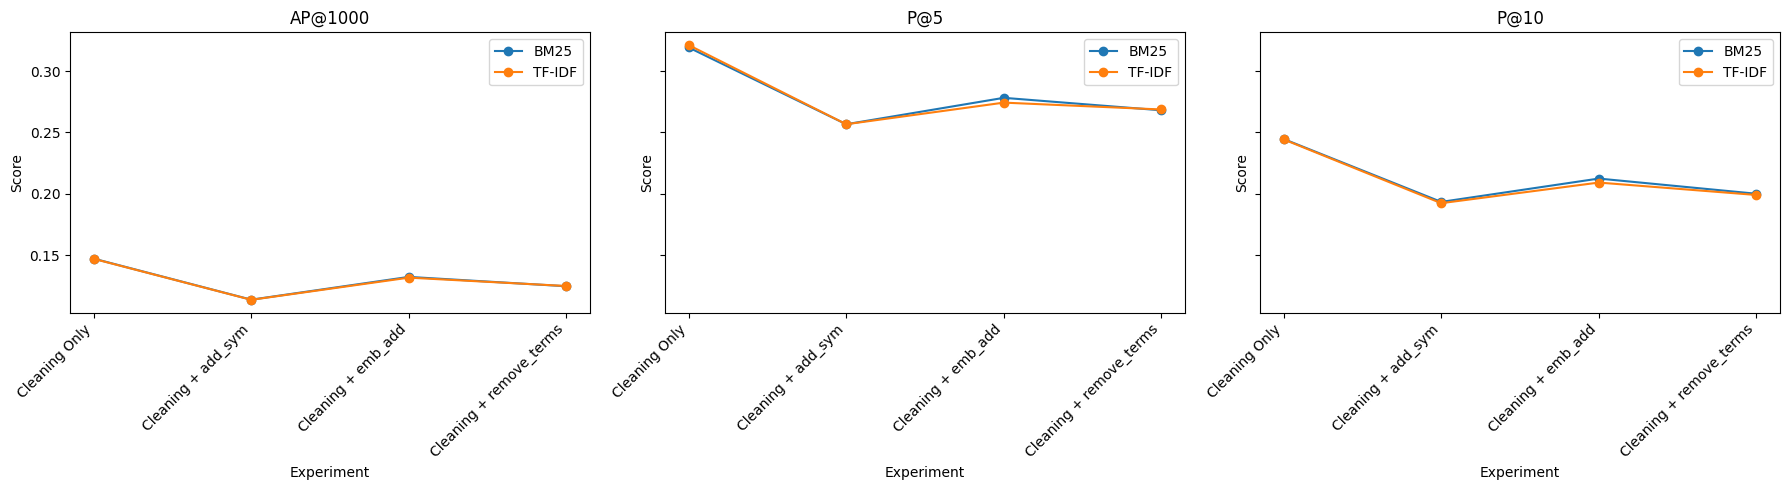

In [101]:
def evaluate_experiment(queries, qrels_df, bm25, tfidf, experiments, metrics=[AP@1000, P@5, P@10]):
    """
    Evaluates BM25 and TF-IDF models across multiple preprocessing experiments.
    Evaluates BM25 and TF-IDF models across multiple preprocessing experiments.

    Args:
    queries (pd.DataFrame): DataFrame containing original queries.
    qrels_df (pd.DataFrame): DataFrame containing relevance judgments.
    bm25: PyTerrier BM25 retrieval model.
    tfidf: PyTerrier TF-IDF retrieval model.
    experiments (list): List of experiments with preprocessing steps.
    metrics (list, optional): List of evaluation metrics. Defaults to ['AP@1000', 'P@5', 'P@10'].

    Returns:
    dict: Results containing scores for each experiment and metric.
    """
    results = []

    for experiment in experiments:
        # Create a copy of the original queries DataFrame
        processed_queries = queries.copy()
        
        # Apply preprocessing steps sequentially
        for step in experiment["steps"]:
            processed_queries['query'] = processed_queries['query'].apply(step)
        
        # Evaluate BM25 and TF-IDF
        models_results = evaluate_and_visualize(processed_queries, qrels_df, bm25, tfidf, metrics)
        
        # Store results for the experiment
        results.append({
            "experiment": experiment["name"],
            "bm25": models_results["BM25"],
            "tfidf": models_results["TF-IDF"]
        })

    # Return collected results
    return results

# Define the preprocessing steps for experiments
experiments = [
    {"name": "Cleaning Only", "steps": [clean_query]},
    {"name": "Cleaning + add_sym", "steps": [clean_query, add_sym]},
    {"name": "Cleaning + emb_add", "steps": [clean_query, emb_add]},
    {"name": "Cleaning + remove_terms", "steps": [clean_query, remove_terms]},
]

# Evaluate experiments and visualize results
results = evaluate_experiment(queries, qrels_df, bm25, tfidf, experiments)
plot_experiment_results(results, metrics=['AP@1000', 'P@5', 'P@10'])

# Third Test: Evaluating Query Expansion Using Qwen Model

In this third test, we aimed to enhance the search queries by expanding them using a pretrained **Qwen model**. The goal was to assess whether expanding queries into multiple variations could improve the retrieval performance.

### Experiment Overview:

The following steps were taken to expand the queries:

1. **Query Expansion**: 
    - The `expand_single_query` function was used to generate **multiple query variations** for each input query using the Qwen model. 
    - For each query, we generated **3 expanded versions** that express the same intent but with different phrasing.

2. **Process**:
    - The Qwen model generates expanded queries by rephrasing the original query. These expansions are then processed by:
      - **Cleaning**: Removing unnecessary punctuation, lowercasing the terms, and handling any extra spaces.
      - **Tokenization**: Ensuring the expansions are tokenized correctly to fit within the model's input constraints.

3. **Expanding Multiple Queries**:
    - The `expand_queries` function applied the expansion process to all queries in the provided **queries DataFrame**, resulting in a new DataFrame with expanded queries.
    - After expansion, the queries were split into multiple rows, preserving the original query ID (`qid`) for reference.

4. **Model Evaluation**:
    - The newly expanded queries were evaluated using the same models as in the previous tests (BM25 and TF-IDF).
    - The `evaluate_and_visualize` function was used to assess the performance of the models on the expanded queries.
    - Results were visualized using the `plot_model_results` function.

In [102]:
def expand_single_query(query: str, model, tokenizer, num_expansions: int = 3) -> list:
    """
    Expands a single search query using the Qwen model to generate multiple variations of the original query.
    
    This function takes an input query and expands it into multiple variations, maintaining the original intent 
    but using different phrasing. The expansions are generated using a pretrained model and tokenizer (e.g., Qwen).
    
    Args:
    query (str): The input search query to be expanded.
    model: The language model used for generating query expansions (e.g., Qwen).
    tokenizer: The tokenizer associated with the model.
    num_expansions (int, optional): The number of expansions to generate. Default is 3.
    
    Returns:
    str: A comma-separated string of the top query expansions.
    """
    # Construct a prompt that instructs the model to expand the query
    prompt = f"""Expand the following query in {num_expansions} different ways. Each expansion should express the same intent but using different phrasing. Do not include any explanations, numbers, or unnecessary text:
    "{query}"
    Provide only the expanded queries, one per line, without any introductory or concluding text."""

    # Prepare the input to feed into the tokenizer
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate the output using the model without tracking gradients (inference mode)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.1,
            num_return_sequences=1
        )

    # Decode the generated response from the model
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_text = response.split(prompt)[-1].strip()

    # Remove any introductory/explanatory text that might be included in the response
    generated_text = re.sub(r"(?i)^(search term to expand:|example:|suggestions:|possible queries:).*", "", generated_text).strip()

    # Remove numbers at the beginning of each expansion (e.g., "1.", "2.", etc.)
    generated_text = re.sub(r"^\d+\.?\s*", "", generated_text)

    # Process each expansion: remove extra spaces, convert to lowercase, and clean non-alphanumeric characters
    expansions = [q.strip() for q in generated_text.split('\n') if q.strip()]

    # Further process each expansion: lowercase and remove non-alphanumeric characters (keeping spaces and basic punctuation)
    processed_expansions = []
    for expansion in expansions:
        expansion = expansion.lower()  # Convert to lowercase
        expansion = re.sub(r'[^\w\s]', '', expansion)  # Remove non-alphanumeric characters
        processed_expansions.append(expansion)

    # Join the top expansions into a single comma-separated string
    final = ', '.join(processed_expansions[:num_expansions])

    # Debugging: Show the generated expansions
    print(f"Generated text: {final}")

    # Return the processed expansions as a single comma-separated string
    return final

def expand_queries(df: pd.DataFrame) -> pd.DataFrame:
    """
    Expands all queries in a DataFrame using the Qwen model.

    This function applies the `expand_single_query` function to each query in the DataFrame, 
    expanding each query into multiple variations using the Qwen model.

    Args:
    df (pd.DataFrame): The DataFrame containing queries to be expanded.
    
    Returns:
    pd.DataFrame: A new DataFrame with expanded queries.
    """
    # Initialize model and tokenizer from pretrained Qwen model
    model_name = "Qwen/Qwen2.5-1.5B-Instruct"
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map=device,
        trust_remote_code=True,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32
    )

    # Create a copy of the input DataFrame to store results
    result_df = df.copy()

    # Use tqdm to show a progress bar while expanding queries
    tqdm.pandas(desc="Expanding queries")
    
    # Apply the query expansion function to each query in the DataFrame
    result_df['query'] = result_df['query'].progress_apply(
        lambda x: expand_single_query(x, model, tokenizer)
    )

    return result_df

processed_queries = queries.copy()

# Apply the query expansion to the 'queries' DataFrame
processed_queries = expand_queries(processed_queries)

Expanding queries:   1%|▏                       | 2/323 [00:06<16:25,  3.07s/it]

Generated text:  are there studies linking statins to an increased risk of breast cancer,  could it be possible that some people are more susceptible to developing breast cancer when taking statins,  is there a correlation between the use of statins and the incidence of breast cancer


Expanding queries:   1%|▏                       | 3/323 [00:19<38:22,  7.20s/it]

Generated text: utilizing autophagy for extended lifespan, activating autophagy for longevity benefits, enhancing autophagy for increased lifespan potential


Expanding queries:   1%|▎                       | 4/323 [00:28<41:42,  7.84s/it]

Generated text:  what are some foods that can help lower the intake of alkylphenols,  how can i incorporate more fruits and vegetables into my daily meals to decrease my consumption of alkylphenols,  which specific types of fish and seafood contain less alkylphenol content compared to other options to further reduce my exposure what are some alternative protein sources i could consider incorporating into my diet


Expanding queries:   2%|▎                       | 5/323 [00:32<35:57,  6.78s/it]

Generated text:  what factors are contributing to americas growing obesity epidemic,  which elements are influencing the increase of overweight individuals in the united states,  how do various causes contribute to the rise in obesity rates among americans


Expanding queries:   2%|▍                       | 6/323 [00:47<49:08,  9.30s/it]

Generated text:  curcumin is a compound found in turmeric that has antiinflammatory properties,  curcumin can interact with certain medications and cause side effects,  curcumin may have potential health benefits for some people but caution is advised to expand the original query who should be careful about curcumin here are three different ways to phrase it


Expanding queries:   2%|▌                       | 7/323 [00:53<44:20,  8.42s/it]

Generated text: foods rich in omega3 fatty acids, fatty fish like salmon and mackerel are good sources of omega3s, omega3 supplements can also be beneficial for those with glaucoma


Expanding queries:   2%|▌                       | 8/323 [00:58<38:12,  7.28s/it]

Generated text:  what ingredients are included within a typical chicken nugget,  could you tell me about all of the components that make up a standard chicken nugget,  what specific items compose each individual chicken nugget


Expanding queries:   3%|▋                       | 9/323 [01:12<48:42,  9.31s/it]

Generated text: meat purge a video game developed by rockstar games, cola a carbonated beverage made from fermented sugar syrup, 1 what are the similarities between a video game called meat purge and a popular carbonated drink known as cola


Expanding queries:   3%|▋                      | 10/323 [01:16<40:43,  7.81s/it]

Generated text: chronic headaches and pork parasites can be treated with medication, chronic headaches caused by pork parasites are treatable with medication, medication is effective for treating chronic headaches associated with pork parasites


Expanding queries:   3%|▊                      | 11/323 [01:31<50:59,  9.81s/it]

Generated text:  preventing early onset of heart disease through education and lifestyle changes among children,  eradicating childhood heart disease by promoting healthy habits from a young age,  addressing childhood heart disease risk factors with targeted interventions for youth


Expanding queries:   4%|▊                      | 12/323 [01:45<58:00, 11.19s/it]

Generated text:  ingredients containing food dyes and their effects on attention deficit hyperactivity disorder adhd,  list of common food dyes and their potential impact on individuals with attention deficit hyperactivity disorder adhd,  identification of food dyes used in various products and their relation to attention deficit hyperactivity disorder adhd


Expanding queries:   4%|▉                      | 13/323 [01:50<47:23,  9.17s/it]

Generated text:  what are some natural remedies for keeping hands warm,  how can i use citrus fruits to enhance hand warmth naturally,  can you suggest a recipe that incorporates citrus to keep my hands cozy


Expanding queries:   4%|▉                      | 14/323 [01:55<42:01,  8.16s/it]

Generated text:  eliminating tumors access to oxygen and nutrients through disrupting their blood vessels,  destroying tumors by blocking their ability to receive essential resources from the bloodstream,  depriving tumors of their sustenance by interfering with nutrient delivery via blood flow


Expanding queries:   5%|█                      | 15/323 [01:59<35:05,  6.84s/it]

Generated text:  are dental xrays considered safe for patients,  is it safe to undergo dental xray procedures,  can dental xrays be deemed as safe


Expanding queries:   5%|█▏                     | 16/323 [02:04<31:49,  6.22s/it]

Generated text:  what are some effective methods for taking probiotics,  how can i incorporate probiotic supplements into my daily routine effectively,  what strategies do people commonly use to ensure proper intake of probiotics


Expanding queries:   5%|█▏                     | 17/323 [02:09<30:16,  5.94s/it]

Generated text:  how does drinking alcohol affect breast cancer risk,  what are the recommended limits for alcohol consumption to reduce breast cancer risk,  are there specific guidelines on moderate alcohol intake for women with a history of breast cancer


Expanding queries:   6%|█▎                     | 18/323 [02:24<43:02,  8.47s/it]

Generated text:  methods to reduce cellulite on legs,  exercise routines for reducing cellulite,  dietary changes for minimizing cellulite


Expanding queries:   6%|█▎                     | 19/323 [02:28<36:10,  7.14s/it]

Generated text:  effective remedies for alleviating constipation symptoms,  optimal strategies to alleviate and prevent constipation,  ideal approaches to managing and treating constipation


Expanding queries:   6%|█▍                     | 20/323 [02:32<31:13,  6.18s/it]

Generated text:  is it advisable to refrain from utilizing titanium dioxide,  could there be a reason for avoiding titanium dioxide,  should consideration be given to omitting titanium dioxide


Expanding queries:   7%|█▍                     | 21/323 [02:38<31:24,  6.24s/it]

Generated text:  reducing consumption of processed meats to minimize exposure to potential carcinogenic compounds,  selecting fresh produce over preserved foods to reduce intake of suspected carcinogens,  choosing lean cuts of red meat and avoiding hightemperature cooking methods to decrease risk of cancer


Expanding queries:   7%|█▌                     | 22/323 [02:52<43:34,  8.68s/it]

Generated text:  strategies to improve skin health through plantbased eating for individuals with psoriasis,  benefits of incorporating a plantbased diet into treatment plans for psoriasis patients,  exploring the impact of adopting a plantbased lifestyle on psoriasis symptoms and overall wellbeing


Expanding queries:   7%|█▋                     | 23/323 [03:00<41:13,  8.25s/it]

Generated text:  utilizing fenugreek seeds to enhance muscular endurance and power output through resistance training exercises,  incorporating fenugreek into a diet plan for athletes aiming to boost their performance by strengthening muscles,  exploring the potential of fenugreek as an ingredient in nutritional supplements designed to augment physical fitness and muscle development


Expanding queries:   7%|█▋                     | 24/323 [03:03<33:50,  6.79s/it]

Generated text: how toxic is our environment, what level of chemical contamination do we have, to what extent are we exposed to harmful chemicals


Expanding queries:   8%|█▊                     | 25/323 [03:17<45:01,  9.06s/it]

Generated text:  managing a large prostate through nutrition,  prostate enlargement treatment via food choices,  dietary approach to managing an enlarged prostate


Expanding queries:   8%|█▊                     | 26/323 [03:24<40:45,  8.24s/it]

Generated text:  the ideal amount of phytosterols to consume for optimal health benefits,  what is the most effective way to obtain high levels of phytosterols,  how can i determine the best phytosterol intake for achieving maximum health advantages


Expanding queries:   8%|█▉                     | 27/323 [03:38<49:41, 10.07s/it]

Generated text:  is there scientific evidence that supports the claim that caffeinecontaining teas can lead to dehydration,  could you provide a detailed analysis of how caffeine affects hydration levels and potential risks associated with consuming caffeinated beverages,  what are some alternative options for those who prefer caffeinated drinks but want to avoid dehydration to expand the original query about whether caffeinated tea is truly dehydrating here are three different ways to phrase it


Expanding queries:   9%|█▉                     | 28/323 [03:43<41:35,  8.46s/it]

Generated text:  is mercury testing necessary for women planning to conceive,  should pregnant women undergo mercury testing prior to conception,  what are the benefits of having mercury testing done during preconception care


Expanding queries:   9%|██                     | 29/323 [03:48<36:28,  7.44s/it]

Generated text:  what is the relationship between stool size and breast cancer risk,  how does stool size correlate with an increased likelihood of developing breast cancer,  can changes in stool size be associated with a higher chance of breast cancer occurrence


Expanding queries:   9%|██▏                    | 30/323 [03:54<33:59,  6.96s/it]

Generated text: explore vitamin ds role in bone health and its impact on overall wellbeing, investigate how adequate levels of vitamin d affect immune function and mental health, analyze the latest research on vitamin d supplementation for preventing chronic diseases


Expanding queries:  10%|██▏                    | 31/323 [04:08<44:40,  9.18s/it]

Generated text:  the relationship between breast cancer and dietary habits,  effects of diet on breast cancer risk reduction,  impact of diet on prevention and treatment of breast cancer


Expanding queries:  10%|██▎                    | 32/323 [04:14<40:20,  8.32s/it]

Generated text: can these spices help reduce the impact of eating a lot of fat, could adding these spices to your diet before indulging in fatty foods potentially mitigate their negative effects, are there specific antioxidants found in these spices that might neutralize the harmful components of a heavy meal


Expanding queries:  10%|██▎                    | 33/323 [04:21<38:21,  7.94s/it]

Generated text:  dioxins accumulate in human adipose tissue and could potentially elevate the likelihood of developing diabetes,  our bodys fat stores can hold dioxins which might contribute to an increased chance of getting diabetes,  the presence of dioxins within our fat cells is linked with a higher risk of contracting diabetes


Expanding queries:  11%|██▍                    | 34/323 [04:29<37:38,  7.81s/it]

Generated text:  another research indicates that lcarnitine may be beneficial to cardiovascular health,  a recent investigation suggests that lcarnitine could enhance cardiac function and reduce risk factors associated with heart disease,  studies have revealed that lcarnitine supplementation might improve lipid profiles and lower blood pressure levels contributing to better heart health


Expanding queries:  11%|██▍                    | 35/323 [04:39<40:44,  8.49s/it]

Generated text:  latest developments regarding the alarming in vitro avocado research findings,  most recent updates concerning the frightening results of the in vitro avocado experiments,  current status inquiries into the unsettling outcomes from the in vitro avocado studies


Expanding queries:  11%|██▌                    | 36/323 [04:45<36:39,  7.66s/it]

Generated text:  how does dr jenkins perceive the validity of paleolithic diets,  what is your opinion regarding dr jenkins stance on paleolithic eating habits,  in what manner does dr jenkins evaluate the reliability of paleolithic dietary practices


Expanding queries:  11%|██▋                    | 37/323 [04:51<34:35,  7.26s/it]

Generated text:  what is the effect of combining pepper and turmeric with v8 juice,  how does mixing pepper and turmeric with v8 juice impact its nutritional value,  in what way does blending pepper and turmeric into a v8 juice composition alter its flavor profile


Expanding queries:  12%|██▋                    | 38/323 [04:56<31:13,  6.57s/it]

Generated text:  is annatto food coloring considered safe for human consumption,  could annatto food coloring be deemed as a safe option for dietary use,  can we assert that annatto food coloring is deemed safe for edible applications


Expanding queries:  12%|██▊                    | 39/323 [05:10<42:10,  8.91s/it]

Generated text:  fresh fruits are more nutritious and have a higher water content compared to frozen fruits,  frozen fruits can be preserved for longer periods and retain their texture and flavor better than fresh fruits,  when choosing between fresh and frozen fruits consider factors such as availability cost and personal preference fresh fruits may offer a wider variety of nutrients and antioxidants while frozen fruits can be convenient options for those who prefer them precut or readytoeat additionally frozen fruits often contain added sugars and preservatives that may not be present in fresh fruits so its important to read labels carefully when purchasing frozen products ultimately both fresh and frozen fruits can be healthy choices depending on your specific needs and preferences fresh fruits are typically


Expanding queries:  12%|██▊                    | 40/323 [05:18<40:27,  8.58s/it]

Generated text:  are there studies that compare the effectiveness of krill oil and fish oil for treating specific health conditions,  what are the potential benefits and drawbacks of consuming krill oil versus fish oil as a dietary supplement,  how do the nutritional profiles of krill oil and fish oil differ and what implications does this have for their use in supplementation


Expanding queries:  13%|██▉                    | 41/323 [05:22<33:47,  7.19s/it]

Generated text:  is apple cider vinegar beneficial to health,  can apple cider vinegar be used as a natural remedy,  what are the potential benefits of consuming apple cider vinegar


Expanding queries:  13%|██▉                    | 42/323 [05:27<30:10,  6.44s/it]

Generated text: how do i convince someone to trust a scientific study, what methods are there for convincing others of the validity of scientific studies, how might one approach persuading people about the reliability of scientific research


Expanding queries:  13%|███                    | 43/323 [05:41<41:44,  8.94s/it]

Generated text: which form of vitamin d is more effective for bone health is it better to take vitamin d3 cholecalciferol over vitamin d2 ergocalciferol are there studies that compare the benefits and risks of these two forms of vitamin d, is vitamin d3 cholecalciferol superior to vitamin d2 ergocalciferol when considering their impact on bone density can we conclude from research that vitamin d3 offers a higher efficacy than vitamin d2, in terms of bone health which type of vitamin dd3 cholecalciferol or d2 ergocalciferolshould be preferred does evidence suggest


Expanding queries:  14%|███▏                   | 44/323 [05:45<34:14,  7.36s/it]

Generated text:  incidents involving vehicles,  unforeseen events causing harm to people and property,  negative occurrences leading to injuries or damage


Expanding queries:  14%|███▏                   | 45/323 [06:00<43:50,  9.46s/it]

Generated text:  adenovirus type 36,  adenovirus strain 36,  type 36 adenovirus


Expanding queries:  14%|███▎                   | 46/323 [06:02<34:15,  7.42s/it]

Generated text: african american, black and african american, person of african descent


Expanding queries:  15%|███▎                   | 47/323 [06:15<41:14,  8.96s/it]

Generated text:  automatic metal detectors at airports,  portable security devices used for screening passengers,  metal detection systems employed by airlines and customs officials


Expanding queries:  15%|███▍                   | 48/323 [06:22<38:55,  8.49s/it]

Generated text: allis favorite color is blue, alli enjoys reading books on history, alli loves playing soccer with her friends


Expanding queries:  15%|███▍                   | 49/323 [06:36<46:48, 10.25s/it]

Generated text: alternative health remedies, natural healing methods, complementary medical practices


Expanding queries:  15%|███▌                   | 50/323 [06:47<46:27, 10.21s/it]

Generated text: the american dental association is a professional organization dedicated to promoting oral health and educating the public about dental care, 2 founded in 1868 the american dental association serves as an advocate for dentists and patients alike by advocating for policies that benefit both professions and consumers, 3 the american dental association is a nonprofit organization whose mission is to advance the science of dentistry through research education and advocacy while also fostering collaboration among its members


Expanding queries:  16%|███▋                   | 51/323 [06:51<38:17,  8.45s/it]

Generated text: amnesia is a condition where an individual experiences memory loss, the term amnesia refers to the state of having lost memories, individuals suffering from amnesia often experience memory impairment


Expanding queries:  16%|███▋                   | 52/323 [06:57<35:27,  7.85s/it]

Generated text: an aneurysm is a bulge in a blood vessel that can burst and cause serious bleeding, aneurysms are abnormal dilations of blood vessels caused by weakening of the wall, the condition known as aneurysm refers to a localized dilation of a blood vessel


Expanding queries:  16%|███▊                   | 53/323 [07:06<35:51,  7.97s/it]

Generated text: anisakiasis, anisakidosis, anisakiasislike illness


Expanding queries:  17%|███▊                   | 54/323 [07:20<44:20,  9.89s/it]

Generated text:  antinutritional substances,  nutrientdepleting compounds,  food inhibitors of nutrient absorption


Expanding queries:  17%|███▉                   | 55/323 [07:34<50:10, 11.23s/it]

Generated text:  sleep apnea,  snoring and sleep apnea,  breathing difficulties during sleep


Expanding queries:  17%|███▉                   | 56/323 [07:38<39:46,  8.94s/it]

Generated text: arkansas state capital is little rock, the capital of arkansas is located in little rock, little rock serves as the capital city of arkansas


Expanding queries:  18%|████                   | 57/323 [07:49<41:56,  9.46s/it]

Generated text:  vitamin c,  antioxidant compound found in citrus fruits and vegetables,  essential nutrient for maintaining healthy skin bones and blood vessels


Expanding queries:  18%|████▏                  | 58/323 [08:03<48:16, 10.93s/it]

Generated text: atkins diet plan, lowcarb atkins meal plan, weight loss atkins diet guide


Expanding queries:  18%|████▏                  | 59/323 [08:15<50:00, 11.36s/it]

Generated text:  fruits that are green and round with a soft texture and a distinct flavor,  nutty buttery fruits that grow on trees and have a creamy consistency when ripe,  yellowishbrown fruits with a smooth skin that can be used for making guacamole the expanded queries are


Expanding queries:  19%|████▎                  | 60/323 [08:19<40:03,  9.14s/it]

Generated text:  i want to buy a bagel,  can you recommend some delicious bagels,  where can i find the best bagels in town


Expanding queries:  19%|████▎                  | 61/323 [08:24<34:27,  7.89s/it]

Generated text:  the quantity of beans that are available at the market today,  beans a popular ingredient used in various cuisines around the world,  a list of all types and varieties of beans currently cultivated


Expanding queries:  19%|████▍                  | 62/323 [08:31<32:34,  7.49s/it]

Generated text: query benzene, expanded queries, 1 the chemical compound with the molecular formula c6h6


Expanding queries:  20%|████▍                  | 63/323 [08:36<29:25,  6.79s/it]

Generated text:  the consumption of betel nuts has been linked to various health risks,  betel nuts are a popular snack among many cultures worldwide,  i am looking for information on the nutritional value of betel nuts


Expanding queries:  20%|████▌                  | 64/323 [08:40<25:59,  6.02s/it]

Generated text:  how can i improve my bioavailability of nutrients,  what are some strategies to enhance nutrient bioavailability,  how do i increase my bodys absorption and utilization of nutrients


Expanding queries:  20%|████▋                  | 65/323 [08:45<24:32,  5.71s/it]

Generated text:  the color of black raspberries is dark purple,  black raspberries are known for their deep shade of red and black,  raspberries that have been picked early often retain a darker hue


Expanding queries:  20%|████▋                  | 66/323 [09:00<35:33,  8.30s/it]

Generated text:  clot formation in blood vessels,  formation of blood clots within the body,  process by which blood forms clots


Expanding queries:  21%|████▊                  | 67/323 [09:05<31:59,  7.50s/it]

Generated text:  the location of bmaa,  bmaas meaning and significance,  a detailed explanation of bmaa the location of bmaa


Expanding queries:  21%|████▊                  | 68/323 [09:08<25:27,  5.99s/it]

Generated text:  broken bones,  fractured bone injuries,  bone breaks and dislocations


Expanding queries:  21%|████▉                  | 69/323 [09:13<25:07,  5.94s/it]

Generated text: query find a restaurant near me that serves italian cuisine, expanded queries, 1 locate an italian restaurant within my vicinity


Expanding queries:  22%|████▉                  | 70/323 [09:28<35:40,  8.46s/it]

Generated text:  breast cancer susceptibility genes,  hereditary breast and ovarian cancer genes,  genetic markers associated with breast cancer risk


Expanding queries:  22%|█████                  | 71/323 [09:42<42:57, 10.23s/it]

Generated text:  pain in the breast area,  chest discomfort related to the breasts,  mammographic findings suggestive of breastrelated issues


Expanding queries:  22%|█████▏                 | 72/323 [09:51<41:28,  9.92s/it]

Generated text:  bronchiolitis obliterans is a rare lung condition characterized by inflammation and scarring of small airways,  bronchiolitis obliterans refers to a specific type of chronic obstructive pulmonary disease copd that affects the smallest air passages in the lungs,  bronchiolitis obliterans is an uncommon form of interstitial lung disease where the tiny air tubes become blocked and damaged over time


Expanding queries:  23%|█████▏                 | 73/323 [10:06<46:52, 11.25s/it]

Generated text: bush administration, the bush administration, administration of george w bush


Expanding queries:  23%|█████▎                 | 74/323 [10:11<38:38,  9.31s/it]

Generated text: the smell of cadaverine is unmistakable, cadaverine has a pungent odor that cannot be ignored, the presence of cadaverine can be detected by its strong and unpleasant scent


Expanding queries:  23%|█████▎                 | 75/323 [10:14<31:22,  7.59s/it]

Generated text:  reducing calorie intake,  limiting food consumption by decreasing caloric content,  introducing a diet that involves eating less energyrich foods


Expanding queries:  24%|█████▍                 | 76/323 [10:26<37:09,  9.03s/it]

Generated text:  painful ulcers on the mouth,  sores that cause discomfort and pain in the oral cavity,  inflammable lesions within the lips and gums to expand the query canker sores here are three different ways to phrase it


Expanding queries:  24%|█████▍                 | 77/323 [10:41<43:27, 10.60s/it]

Generated text:  substances that cause cancer,  agents responsible for carcinogenesis,  chemicals linked to malignancy development


Expanding queries:  24%|█████▌                 | 78/323 [10:55<47:52, 11.73s/it]

Generated text: carrageenan extract, seaweedbased carrageenan product, modified carrageenan for food applications


Expanding queries:  24%|█████▋                 | 79/323 [11:03<42:31, 10.46s/it]

Generated text:  vegetable that is white and has a head shape,  cultural symbol of italy,  food item used as a garnish for pasta dishes the expanded queries are


Expanding queries:  25%|█████▋                 | 80/323 [11:17<47:05, 11.63s/it]

Generated text:  the best chanterelle mushrooms for cooking,  where to find fresh chanterelle mushrooms near me,  chanterelle mushroom recipes and cooking tips the best chanterelle mushrooms for cooking are available at local markets or specialty food stores you can also try searching online for recommendations from other chefs who have used them successfully in their dishes fresh chanterelle mushrooms are often found in season during autumn months when they grow abundantly in forests across north america to ensure you get the freshest variety look for those that come with a stem intact and firm texture when selecting choose ones that are bright orangeyellow in color and free of any signs of mold or damage once home store


Expanding queries:  25%|█████▊                 | 81/323 [11:27<44:30, 11.03s/it]

Generated text: chernobyl disaster, the nuclear accident at chernobyl, the incident at chernobyl nuclear power plant


Expanding queries:  25%|█████▊                 | 82/323 [11:31<36:14,  9.02s/it]

Generated text:  i want to buy chickpeas,  can you recommend some recipes that use chickpeas,  where can i find a store that sells chickpeas


Expanding queries:  26%|█████▉                 | 83/323 [11:38<33:20,  8.34s/it]

Generated text: chlorophyll is a pigment found in plants that helps them absorb sunlight for photosynthesis, chlorophyll can be used to make food and energy by plants through the process of photosynthesis, chlorophyll is essential for plant growth and development as it plays a crucial role in converting light into chemical energy


Expanding queries:  26%|█████▉                 | 84/323 [11:50<37:28,  9.41s/it]

Generated text:  sweet spice that is often used in baking and desserts,  the aromatic flavoring derived from the bark of a tree,  a key ingredient for making cinnamon rolls and other holiday treats the expanded queries are


Expanding queries:  26%|██████                 | 85/323 [12:04<43:13, 10.90s/it]

Generated text:  the illegal drug known as cocaine,  a stimulant that is highly addictive and often used for recreational purposes,  an illicit substance characterized by its euphoric effects and potential for abuse


Expanding queries:  27%|██████                 | 86/323 [12:10<37:27,  9.48s/it]

Generated text:  hot beverage that is typically consumed by people for its caffeine content and aroma,  liquid drink made from roasted coffee beans often served hot with milk or cream,  brewed product derived from ground coffee beans commonly used as a stimulant and flavor enhancer


Expanding queries:  27%|██████▏                | 87/323 [12:16<32:38,  8.30s/it]

Generated text:  the patient is currently in a coma,  a person has fallen into a state of unconsciousness known as a coma,  someone is experiencing a condition where they are completely unaware and unresponsive to their surroundings commonly referred to as a coma


Expanding queries:  27%|██████▎                | 88/323 [12:30<39:37, 10.12s/it]

Generated text:  methods of cooking,  ways to cook,  techniques for cooking


Expanding queries:  28%|██████▎                | 89/323 [12:36<34:32,  8.85s/it]

Generated text: cortisol levels are high during stress, cortisol is elevated when under pressure, high cortisol levels occur with anxiety and fear


Expanding queries:  28%|██████▍                | 90/323 [12:50<40:48, 10.51s/it]

Generated text:  infant mortality due to sudden infant death syndrome,  sudden infant death syndrome deaths among infants under one year old,  infants who died from unknown causes at birth


Expanding queries:  28%|██████▍                | 91/323 [12:55<33:20,  8.62s/it]

Generated text:  the use of cumin in mexican cuisine,  cumins role as a spice in indian cooking,  exploring the history and uses of cumin


Expanding queries:  28%|██████▌                | 92/323 [12:59<28:53,  7.50s/it]

Generated text: czechoslovakias capital city, the country that was once known as czechoslovakia is now divided into two separate countries, a brief history of czechoslovakia and its dissolution into two independent states


Expanding queries:  29%|██████▌                | 93/323 [13:05<26:10,  6.83s/it]

Generated text: deafness is a condition that affects hearing ability, the term deafness refers to impaired hearing, impaired hearing can be caused by various factors such as aging illness injury or genetic predisposition


Expanding queries:  29%|██████▋                | 94/323 [13:13<28:19,  7.42s/it]

Generated text: dha is a type of omega3 fatty acid that supports brain health and reduces inflammation, dha stands for docosahexaenoic acid an essential nutrient found in fish oil supplements and certain foods like salmon and mackerel, docosahexaenoic acid dha is a crucial component of cell membranes particularly important for maintaining healthy vision and cognitive function


Expanding queries:  29%|██████▊                | 95/323 [13:22<29:21,  7.73s/it]

Generated text:  evaluation of nutritional value based on specific criteria,  assessment of food items healthiness according to established standards,  analysis of dietary components for their impact on overall wellness


Expanding queries:  30%|██████▊                | 96/323 [13:30<29:55,  7.91s/it]

Generated text:  the substance known as domoic acid is a neurotoxin produced by certain types of algae,  domoic acid also referred to as amnesic shellfish poisoning asp affects marine life and humans alike,  this chemical compound commonly found in certain species of pinnipeds and bivalves has been linked to various health issues


Expanding queries:  30%|██████▉                | 97/323 [13:45<37:04,  9.84s/it]

Generated text: dr dean ornish is a renowned cardiologist and author who has dedicated his life to promoting healthy living through diet and lifestyle changes, 1 dr dean ornish a prominent cardiologist and wellness advocate offers comprehensive guidance on adopting a hearthealthy diet and incorporating sustainable habits for optimal health, 2 dr dean ornish an esteemed cardiologist with extensive experience in cardiovascular care shares insights on how to adopt a balanced diet and implement practical strategies for maintaining overall wellbeing


Expanding queries:  30%|██████▉                | 98/323 [13:50<32:16,  8.61s/it]

Generated text:  dr walter willetts research on nutrition and health,  the work of dr walter willett focusing on diet and its impact on human wellbeing,  a biography detailing dr walter willetts contributions to nutritional science and public health advocacy


Expanding queries:  31%|███████                | 99/323 [14:05<38:34, 10.33s/it]

Generated text: ecmo treatment, extracorporeal membrane oxygenation therapy, mechanical circulatory support device for patients with severe respiratory failure and cardiac dysfunction


Expanding queries:  31%|██████▊               | 100/323 [14:15<38:09, 10.27s/it]

Generated text: christmas drink made with alcohol and spices, alcoholic beverage typically served during christmas season, spiced alcoholic concoction commonly consumed at christmas time


Expanding queries:  31%|██████▉               | 101/323 [14:23<35:19,  9.55s/it]

Generated text:  chemicals that interfere with hormone function in living organisms,  substances that affect the bodys endocrine system and lead to hormonal imbalances,  compounds that can alter the normal functioning of hormones within an organism


Expanding queries:  32%|██████▉               | 102/323 [14:28<31:02,  8.43s/it]

Generated text:  enhance athletic performance and provide a quick source of caffeine for energy,  boost physical stamina and offer an immediate boost of energy through their stimulant content,  increase endurance during workouts and deliver a rapid surge of vitality from their energizing properties


Expanding queries:  32%|███████               | 103/323 [14:37<31:12,  8.51s/it]

Generated text:  the compound ergothioneine is a sulfurcontaining amino acid that plays an important role in cellular defense against oxidative stress,  ergothioneine is a sulfurrich amino acid found in various foods and supplements contributing to its antioxidant properties,  this study highlights the importance of ergothioneine as a key component for enhancing immune function and protecting cells from damage caused by free radicals


Expanding queries:  32%|███████               | 104/323 [14:43<27:42,  7.59s/it]

Generated text:  the application of scientific evidence to medical practice and research,  a method that integrates clinical expertise with empirical evidence for making decisions about patient care,  an approach that uses systematic reviews and randomized controlled trials to inform healthcare decisionmaking


Expanding queries:  33%|███████▏              | 105/323 [14:57<34:57,  9.62s/it]

Generated text:  factory farming methods,  industrial livestock production techniques,  largescale animal rearing procedures


Expanding queries:  33%|███████▏              | 106/323 [15:11<39:56, 11.04s/it]

Generated text:  the origin of fava beans,  fava beans for sale at local markets,  recipes that use fava beans as an ingredient


Expanding queries:  33%|███████▎              | 107/323 [15:18<34:54,  9.70s/it]

Generated text: use of fenugreek for improving digestion and reducing cholesterol levels, fenugreek seeds are commonly used to enhance digestive health and lower blood cholesterol, the nutritional benefits of consuming fenugreek leaves can be seen in its ability to improve gut function and reduce triglyceride concentrations


Expanding queries:  33%|███████▎              | 108/323 [15:21<27:52,  7.78s/it]

Generated text: finland, the capital of finland, a country located in northern europe


Expanding queries:  34%|███████▍              | 109/323 [15:29<27:14,  7.64s/it]

Generated text: flax oil is a type of omega3 fatty acid that can be beneficial for heart health, omega3 fatty acids are essential nutrients found in flax oil and other sources like fish and algae, flax oil contains high levels of alphalinolenic acid ala which is an important omega3 fatty acid


Expanding queries:  34%|███████▍              | 110/323 [15:39<30:21,  8.55s/it]

Generated text:  vitamin b9,  folate,  source of vitamin b9


Expanding queries:  34%|███████▌              | 111/323 [15:46<28:05,  7.95s/it]

Generated text: fosamax,  a medication used to treat osteoporosis and other bone conditions,  a brand name for alendronate sodium an oral bisphosphonate used to prevent and treat osteoporosis


Expanding queries:  35%|███████▋              | 112/323 [16:00<34:43,  9.87s/it]

Generated text:  sugars containing fructose,  sweeteners that contain fructose,  products made with fructose


Expanding queries:  35%|███████▋              | 113/323 [16:10<34:37,  9.89s/it]

Generated text:  a rare genetic disorder characterized by a deficiency of galactose1phosphate uridylyltransferase galt leading to accumulation of galactose and other metabolites,  an inherited metabolic disease affecting carbohydrate metabolism due to a defect in galactose1phosphate uridylyltransferase enzyme,  a condition where individuals have an impaired ability to break down galactose resulting in harmful effects on their bodys cells and organs


Expanding queries:  35%|███████▊              | 114/323 [16:13<26:47,  7.69s/it]

Generated text: genetic modification, altering dna sequences to create new traits, changing genes to produce desired characteristics


Expanding queries:  36%|███████▊              | 115/323 [16:18<23:50,  6.88s/it]

Generated text:  a comprehensive analysis of health issues affecting people worldwide,  an extensive examination into the impact of various diseases and conditions on global populations,  a detailed investigation into the prevalence and consequences of illness across all nations


Expanding queries:  36%|███████▉              | 116/323 [16:21<19:55,  5.78s/it]

Generated text:  buy goji berries online,  sell goji berries wholesale,  import goji berries from china


Expanding queries:  36%|███████▉              | 117/323 [16:29<21:59,  6.40s/it]

Generated text:  fruits that are commonly used for making wine,  varieties of fruit that can be used to produce alcoholic beverages,  types of produce that are harvested specifically for their use in crafting spirits grapes


Expanding queries:  37%|████████              | 118/323 [16:43<30:01,  8.79s/it]

Generated text:  agents that stimulate growth and development,  substances used to enhance animal body mass and size,  chemicals designed to boost livestock production efficiency


Expanding queries:  37%|████████              | 119/323 [16:51<29:08,  8.57s/it]

Generated text:  fish that is a member of the porgy family and has a large fleshy body with a dark greenishblue coloration,  large fleshy fish belonging to the porgy family with a dark greenishblue hue,  porgylike fish having a large plump body and an iridescent bluegreen appearance


Expanding queries:  37%|████████▏             | 120/323 [17:05<34:52, 10.31s/it]

Generated text:  harvards second study on physician practices,  the second study conducted by harvard medical professionals,  the research project initiated at harvard focusing on physician activities and outcomes


Expanding queries:  37%|████████▏             | 121/323 [17:09<27:49,  8.26s/it]

Generated text:  he is listening to music,  the sound of his voice can be heard clearly,  she hears a bird singing outside her window


Expanding queries:  38%|████████▎             | 122/323 [17:15<25:57,  7.75s/it]

Generated text: heme iron is a form of iron that can be used by the body to produce hemoglobin and myoglobin, iron from heme sources is more easily absorbed than nonheme iron, the use of heme iron supplements may help improve iron absorption and utilization in individuals with low dietary intake


Expanding queries:  38%|████████▍             | 123/323 [17:18<20:22,  6.11s/it]

Generated text: hernias, surgical procedures for treating hernias, conditions associated with hernias


Expanding queries:  38%|████████▍             | 124/323 [17:23<19:36,  5.91s/it]

Generated text:  hiroshima is a city located in japan,  the atomic bombing of hiroshima occurred on august 6 1945,  hiroshima has been designated as a unesco world heritage site for its historical significance and cultural heritage


Expanding queries:  39%|████████▌             | 125/323 [17:27<17:39,  5.35s/it]

Generated text:  abnormalities in hormone production and secretion,  imbalance of hormones leading to various symptoms,  disorders affecting hormonal regulation causing specific health issues


Expanding queries:  39%|████████▌             | 126/323 [17:30<15:05,  4.60s/it]

Generated text:  excessive activity level,  overactive behavior pattern,  highly energetic state


Expanding queries:  39%|████████▋             | 127/323 [17:44<24:35,  7.53s/it]

Generated text:  insulinlike growth factor one,  igf1 hormone,  insulinlike growth factorone


Expanding queries:  40%|████████▋             | 128/323 [17:54<26:31,  8.16s/it]

Generated text:  chemical compounds released by industrial processes that can cause harm to human health and the environment,  toxins produced by industrial facilities that may pose risks to public safety and ecological balance,  substances emitted from manufacturing industries that could lead to adverse effects on both people and nature


Expanding queries:  40%|████████▊             | 129/323 [18:07<30:56,  9.57s/it]

Generated text: insect species found in tropical rainforests, types of insects commonly observed in dense jungle environments, invertebrates belonging to the order lepidoptera that are frequently spotted in lush forests


Expanding queries:  40%|████████▊             | 130/323 [18:15<28:51,  8.97s/it]

Generated text:  iowa womens health study,  a study focusing on womens health issues in iowa,  the investigation into female wellbeing within the state of iowa


Expanding queries:  41%|████████▉             | 131/323 [18:18<23:16,  7.27s/it]

Generated text: japan, the capital of japan is tokyo, japan is a country located in east asia


Expanding queries:  41%|████████▉             | 132/323 [18:32<29:54,  9.40s/it]

Generated text:  unhealthy fast food,  inedible processed meals,  disgusting sugary snacks


Expanding queries:  41%|█████████             | 133/323 [18:36<24:40,  7.79s/it]

Generated text:  i want to buy kidney beans,  could you recommend some recipes that use kidney beans,  where can i find a store that sells kidney beans


Expanding queries:  41%|█████████▏            | 134/323 [18:42<22:40,  7.20s/it]

Generated text: kohlrabi is a vegetable that can be eaten raw or cooked, kohlrabi is a root vegetable with a mild flavor and crunchy texture, kohlrabi is a member of the cabbage family and is often used as a substitute for broccoli in recipes


Expanding queries:  42%|█████████▏            | 135/323 [18:51<24:30,  7.82s/it]

Generated text: lard is a type of fatty pork fat used as a cooking ingredient,  a lard is a culinary staple that can be used to make crispy fried foods and rich pastries,  the term lard refers to rendered pork fat which has been extracted from the meat through a process called rendering


Expanding queries:  42%|█████████▎            | 136/323 [19:06<30:28,  9.78s/it]

Generated text: leeks are a type of vegetable that can be used in cooking,  leeks are edible plants with white and green parts commonly used as a garnish for soups and stews,  leeks have a mild onion flavor and are often added to salads stirfries and sandwiches


Expanding queries:  42%|█████████▎            | 137/323 [19:12<27:08,  8.76s/it]

Generated text: leucine is an essential amino acid that plays a crucial role in protein synthesis and energy metabolism, leucine is an important component of proteins and has significant implications for muscle growth and recovery, leucine is vital for maintaining healthy muscles and supporting overall metabolic function within the body


Expanding queries:  43%|█████████▍            | 138/323 [19:27<32:16, 10.47s/it]

Generated text: pesticide containing lindane, organic compound with chemical formula c19h26o, benzene ring substituted by a hydrocarbon chain of 10 carbon atoms and an oxygen atom


Expanding queries:  43%|█████████▍            | 139/323 [19:33<28:20,  9.24s/it]

Generated text:  the condition affecting the liver that leads to dysfunction of its organs and tissues,  a medical disorder characterized by impaired function of the livers organ systems due to damage or malfunction,  a health issue involving the liver where there is a decline in its ability to perform essential functions


Expanding queries:  43%|█████████▌            | 140/323 [19:40<26:15,  8.61s/it]

Generated text:  diets that are low in carbohydrates,  carbohydraterestricted eating plans,  dietary approaches to lower carbohydrate intake


Expanding queries:  44%|█████████▌            | 141/323 [19:54<31:22, 10.34s/it]

Generated text:  the symptoms of lyme disease,  treatment options for lyme disease patients,  prevalence rates of lyme disease worldwide


Expanding queries:  44%|█████████▋            | 142/323 [20:08<33:49, 11.21s/it]

Generated text:  the benefits of magnesium for health,  magnesium a key mineral for overall wellbeing,  exploring the role of magnesium in maintaining bodily functions and promoting health


Expanding queries:  44%|█████████▋            | 143/323 [20:17<32:09, 10.72s/it]

Generated text:  liquid sweetener made from the sap of maple trees,  natural sugar substitute derived from maple tree exudate,  confectionery ingredient produced by processing maple juice


Expanding queries:  45%|█████████▊            | 144/323 [20:32<35:14, 11.81s/it]

Generated text:  inflammation of the breast tissue caused by bacterial infection,  a painful inflammation of the mammary glands due to a bacterial infection,  an inflammatory condition affecting the breast tissues resulting from a bacterial infection


Expanding queries:  45%|█████████▉            | 145/323 [20:35<27:53,  9.40s/it]

Generated text: medical ethical considerations, the principles of medical ethics, ethical issues in medicine


Expanding queries:  45%|█████████▉            | 146/323 [20:50<32:07, 10.89s/it]

Generated text: memory, recollection, remembrance


Expanding queries:  46%|██████████            | 147/323 [20:54<25:55,  8.84s/it]

Generated text: expand mesquite, expand mesquite tree, expand mesquite beans mesquite


Expanding queries:  46%|██████████            | 148/323 [21:08<30:26, 10.44s/it]

Generated text:  mecavir,  mecavir tablets,  mevacor capsules


Expanding queries:  46%|██████████▏           | 149/323 [21:22<33:41, 11.62s/it]

Generated text:  liquid that is produced by a cow and used as food for humans,  white fluid obtained from the udder of a dairy animal such as a cow or goat,  product derived from the mammary glands of an animal like a cow or goat used primarily for human consumption


Expanding queries:  46%|██████████▏           | 150/323 [21:37<35:52, 12.44s/it]

Generated text: the expanded queries are,  the thick sticky substance used as a sweetener and food additive,  a viscous liquid made from sugarcane or sugar beets that is often used for cooking and baking


Expanding queries:  47%|██████████▎           | 151/323 [21:51<37:19, 13.02s/it]

Generated text:  oral cavity malignancy,  tumor of the oral cavity,  malignant neoplasm of the mouth


Expanding queries:  47%|██████████▎           | 152/323 [22:05<37:41, 13.23s/it]

Generated text:  improving muscle strength and endurance through exercise routines,  enhancing muscular development by engaging in resistance training exercises,  boosting overall physical fitness with a focus on building lean body mass


Expanding queries:  47%|██████████▍           | 153/323 [22:10<30:37, 10.81s/it]

Generated text:  myelopathy is a condition affecting the spinal cord,  the term myelopathy refers to damage or disease of the spinal cord,  a myelopathy involves impairment of motor and sensory functions due to spinal cord dysfunction


Expanding queries:  48%|██████████▍           | 154/323 [22:16<26:23,  9.37s/it]

Generated text:  the organization that conducts research and provides advice to government agencies on science and technology,  a group of experts who work together to advance knowledge and understanding in various fields of study,  an institution dedicated to promoting excellence in scientific research and fostering collaboration among scientists worldwide


Expanding queries:  48%|██████████▌           | 155/323 [22:30<30:25, 10.86s/it]

Generated text: native americans, indigenous peoples of the americas, first nations people of north america


Expanding queries:  48%|██████████▋           | 156/323 [22:38<27:48,  9.99s/it]

Generated text:  the condition known as neurocysticercosis,  neurocysticercosis a medical disorder affecting the brain,  cysticercosis of the central nervous system


Expanding queries:  49%|██████████▋           | 157/323 [22:42<22:19,  8.07s/it]

Generated text: aarp nih study, study on aarp and nih, investigation into aarp and national institutes of health


Expanding queries:  49%|██████████▊           | 158/323 [22:47<20:05,  7.31s/it]

Generated text: norovirus can cause severe gastrointestinal illness, the norovirus is responsible for significant outbreaks of gastroenteritis worldwide, norovirus infection often leads to acute gastroenteritis symptoms such as nausea vomiting diarrhea and abdominal pain


Expanding queries:  49%|██████████▊           | 159/323 [22:56<20:39,  7.56s/it]

Generated text:  food items containing nuts,  almonds and cashews,  nut products for sale


Expanding queries:  50%|██████████▉           | 160/323 [23:10<26:04,  9.60s/it]

Generated text:  green beans,  kale,  lima beans to expand the query okra you could say


Expanding queries:  50%|██████████▉           | 161/323 [23:14<21:21,  7.91s/it]

Generated text:  abnormal epithelial tissue growth,  tumorlike changes in epithelium,  precancerous cell proliferation


Expanding queries:  50%|███████████           | 162/323 [23:28<26:25,  9.85s/it]

Generated text:  organic tin compounds,  tinbased organic materials,  tincontaining organics


Expanding queries:  50%|███████████           | 163/323 [23:43<29:52, 11.20s/it]

Generated text:  meat from oxen,  the flesh of oxen used for food,  animal protein derived from cattle


Expanding queries:  51%|███████████▏          | 164/323 [23:50<27:02, 10.20s/it]

Generated text: panama canal, panama city, republic of panama


Expanding queries:  51%|███████████▏          | 165/323 [24:05<30:09, 11.45s/it]

Generated text:  parkinsons disease,  the condition known as parkinsons disease,  parkinsonism a group of symptoms resembling parkinsons disease


Expanding queries:  51%|███████████▎          | 166/323 [24:19<32:14, 12.32s/it]

Generated text:  the creamy spread made from ground peanuts that is commonly used as a snack and sandwich filling,  a pastelike substance derived from roasted peanuts that is often enjoyed for its taste and versatility,  a food product consisting of ground peanuts blended with other ingredients to create a smooth consistency suitable for consumption


Expanding queries:  52%|███████████▎          | 167/323 [24:24<26:31, 10.20s/it]

Generated text: peoria is a city located in illinois, peoria is an important transportation hub for the midwest region, peoria is known as the gateway to the west due to its strategic location on major highways and railroads


Expanding queries:  52%|███████████▍          | 168/323 [24:39<29:35, 11.45s/it]

Generated text:  chemicals used to kill pests,  agents employed for exterminating insects and other small animals,  remedies applied to eliminate harmful creatures such as rodents and weeds


Expanding queries:  52%|███████████▌          | 169/323 [24:53<31:37, 12.32s/it]

Generated text: philippines, the philippines, philippine islands


Expanding queries:  53%|███████████▌          | 170/323 [24:58<25:56, 10.18s/it]

Generated text:  the amount of phytochemicals present in this food item,  the nutritional value of phytochemicals found in this plantbased diet,  phytochemical content and its impact on human health


Expanding queries:  53%|███████████▋          | 171/323 [25:03<21:28,  8.48s/it]

Generated text:  fresh pineapple slices for sale at local farmers market,  pineapple chunks ready to add to your favorite smoothie recipe,  delicate pineapple flavoring used in gourmet desserts and cocktails


Expanding queries:  53%|███████████▋          | 172/323 [25:17<25:46, 10.24s/it]

Generated text:  diet rich in plantbased foods,  vegan eating plan,  food choices focused on plants


Expanding queries:  54%|███████████▊          | 173/323 [25:28<26:17, 10.52s/it]

Generated text:  plants that are harmful to humans due to their toxicity,  dangerous vegetation containing toxic compounds,  noxious flora with lethal properties


Expanding queries:  54%|███████████▊          | 174/323 [25:34<22:20,  9.00s/it]

Generated text:  a type of synthetic fiber commonly used for making disposable cutlery and packaging,  the material that is often found in grocery bags and food containers,  a thermoplastic polymer with a molecular structure consisting of repeating units of propylene


Expanding queries:  54%|███████████▉          | 175/323 [25:41<20:52,  8.46s/it]

Generated text:  the demand for pork products has been increasing steadily over the past decade,  pork consumption is projected to rise significantly by 2025 due to growing global population and changing dietary preferences,  in recent years there has been a notable increase in the popularity of porkbased dishes among healthconscious consumers


Expanding queries:  54%|███████████▉          | 176/323 [25:53<23:32,  9.61s/it]

Generated text:  workers involved with poultry production,  people employed in poultry farming and processing,  professionals engaged in poultry care and handling


Expanding queries:  55%|████████████          | 177/323 [26:08<26:51, 11.04s/it]

Generated text:  vitamins for pregnant women,  supplements during pregnancy,  gestational health care products


Expanding queries:  55%|████████████          | 178/323 [26:14<23:17,  9.64s/it]

Generated text:  the hormone prolactin,  the production of prolactin by the pituitary gland,  the physiological role of prolactin the hormone prolactin


Expanding queries:  55%|████████████▏         | 179/323 [26:22<21:39,  9.02s/it]

Generated text: prunes are a type of fruit that can be eaten fresh or used in cooking,  prunes are a popular snack for those looking to boost their fiber intake,  prunes have been traditionally used as a natural remedy for constipation and diarrhea


Expanding queries:  56%|████████████▎         | 180/323 [26:36<25:19, 10.63s/it]

Generated text:  sugar pumpkin,  canned pumpkin pie filling,  spicy roasted pumpkin seeds


Expanding queries:  56%|████████████▎         | 181/323 [26:50<27:47, 11.75s/it]

Generated text:  the use of quinine for treating malaria,  quinines role in preventing altitude sickness,  quinine as a natural remedy for insomnia


Expanding queries:  56%|████████████▍         | 182/323 [27:01<26:31, 11.29s/it]

Generated text:  a drug that inhibits cell growth and proliferation,  an agent that slows down cellular reproduction,  a substance that hinders tissue regeneration sure here are three expansions of the query rapamycin


Expanding queries:  57%|████████████▍         | 183/323 [27:15<28:28, 12.21s/it]

Generated text:  dark roasts of red tea,  a cup of blackened red tea leaves,  the vibrant hue of red teas infusion


Expanding queries:  57%|████████████▌         | 184/323 [27:29<29:44, 12.83s/it]

Generated text:  severe muscle breakdown and kidney damage due to rhabdomyolysis,  muscle tissue destruction with potential for renal failure from rhabdomyolysis,  myopathy accompanied by myoglobinuria and elevated creatine kinase levels associated with rhabdomyolysis


Expanding queries:  57%|████████████▌         | 185/323 [27:37<25:45, 11.20s/it]

Generated text:  rickets is a disease characterized by softening of bones and deformities,  the term rickets refers to a condition where theres a deficiency of vitamin d leading to bone weakness and brittleness,  rickets can be caused due to lack of exposure to sunlight which helps in producing vitamin d essential for calcium absorption in bones


Expanding queries:  58%|████████████▋         | 186/323 [27:51<27:43, 12.15s/it]

Generated text: routine, daily schedule, set of daily activities


Expanding queries:  58%|████████████▋         | 187/323 [27:55<21:53,  9.66s/it]

Generated text:  fresh salmon fillets for sale at a local market,  wild caught salmon served with lemon butter sauce,  organic wild salmon sushi rolls


Expanding queries:  58%|████████████▊         | 188/323 [28:07<23:37, 10.50s/it]

Generated text:  high levels of saturated fat,  excess amounts of saturated fats,  unsaturated fats replaced with saturated fats


Expanding queries:  59%|████████████▊         | 189/323 [28:11<18:52,  8.45s/it]

Generated text:  delicious seafood dishes to try,  explore local seafood markets and restaurants,  recipes for making your own seafood delicacies


Expanding queries:  59%|████████████▉         | 190/323 [28:21<19:43,  8.90s/it]

Generated text:  the chemical responsible for regulating mood and sleep cycles,  a neurotransmitter involved in emotional processing and feelings of wellbeing,  the brains primary messenger that affects happiness and anxiety levels


Expanding queries:  59%|█████████████         | 191/323 [28:26<16:58,  7.72s/it]

Generated text:  the period of time during which a product remains safe and effective,  the duration for which a substance can be stored before it becomes unsafe to use,  the timeframe within which a food item is suitable for consumption


Expanding queries:  59%|█████████████         | 192/323 [28:32<15:50,  7.26s/it]

Generated text:  the function of sirtuin proteins,  identification and characterization of sirtuin enzymes,  impact of sirtuin mutations on cellular processes the function of sirtuin proteins identification and characterization of sirtuin enzymes impact of sirtuin mutations on cellular processes


Expanding queries:  60%|█████████████▏        | 193/323 [28:36<13:16,  6.13s/it]

Generated text: smoking cessation program, quit smoking support group, smokefree living tips


Expanding queries:  60%|█████████████▏        | 194/323 [28:44<14:50,  6.90s/it]

Generated text:  improving soil quality through organic farming practices,  enhancing soil fertility by utilizing compost and cover crops,  boosting soil productivity with sustainable agricultural methods


Expanding queries:  60%|█████████████▎        | 195/323 [28:56<17:40,  8.29s/it]

Generated text: fresh spearmint candy, spearmint flavor extract for cooking, natural spearmint essential oil for aromatherapy


Expanding queries:  61%|█████████████▎        | 196/323 [29:09<20:29,  9.68s/it]

Generated text: sugar substitute, diet sweetener alternative, caloriefree artificial sweetener option


Expanding queries:  61%|█████████████▍        | 197/323 [29:13<16:39,  7.94s/it]

Generated text:  st johns wort,  the herb st johns wort,  a plant known as st johns wort


Expanding queries:  61%|█████████████▍        | 198/323 [29:16<14:02,  6.74s/it]

Generated text:  a natural sweetener alternative to sugar,  a plantbased option for those with diabetes,  a lowcalorie substitute for artificial sweeteners


Expanding queries:  62%|█████████████▌        | 199/323 [29:22<13:24,  6.49s/it]

Generated text: subsidies for renewable energy projects, grants available to small businesses for technology upgrades, financial aid offered by government for ecofriendly initiatives


Expanding queries:  62%|█████████████▌        | 200/323 [29:36<17:23,  8.48s/it]

Generated text: the expanded queries are,  the element with atomic number 16,  the chemical compound with formula s


Expanding queries:  62%|█████████████▋        | 201/323 [29:50<20:49, 10.24s/it]

Generated text:  medications containing suppositories,  products that contain suppositories,  items with suppositories as an ingredient


Expanding queries:  63%|█████████████▊        | 202/323 [30:04<23:08, 11.47s/it]

Generated text:  natural sweeteners,  artificial sweeteners,  sugar substitutes


Expanding queries:  63%|█████████████▊        | 203/323 [30:14<22:07, 11.06s/it]

Generated text:  the person with the name taro,  a japanese man named taro,  a male individual bearing the surname of taro sure here are three expansions for the query taro


Expanding queries:  63%|█████████████▉        | 204/323 [30:19<18:22,  9.26s/it]

Generated text:  fermented soy product containing tofulike texture and nutty flavor,  edible block of fermented soybean paste used as a meat substitute,  soybased food item with firm consistency and savory taste


Expanding queries:  63%|█████████████▉        | 205/323 [30:25<16:07,  8.20s/it]

Generated text: thiamine is a vitamin essential for energy production and metabolism, thiamine deficiency can lead to beriberi a disease characterized by heart failure and nerve damage, thiamine plays a crucial role in maintaining healthy brain function and cognitive performance


Expanding queries:  64%|██████████████        | 206/323 [30:31<14:45,  7.57s/it]

Generated text:  titanium dioxide is a white powder used as an additive in paints and plastics,  the chemical compound tio2 has applications in various industries including coatings and automotive parts manufacturing,  titanium dioxide exhibits photocatalytic properties which make it useful for water purification systems and air purifiers


Expanding queries:  64%|██████████████        | 207/323 [30:46<18:33,  9.60s/it]

Generated text:  worm that lives on human tongue,  mouth parasite resembling a worm,  infectious organism commonly found in human mouths


Expanding queries:  64%|██████████████▏       | 208/323 [31:00<21:07, 11.03s/it]

Generated text:  artificially produced unsaturated fatty acids that are detrimental to health,  unsaturated fat substitutes with no nutritional value,  hydrogenated vegetable oils containing harmful components


Expanding queries:  65%|██████████████▏       | 209/323 [31:04<16:54,  8.90s/it]

Generated text: tufts university, the tufts university campus, a visit to tufts university


Expanding queries:  65%|██████████████▎       | 210/323 [31:08<14:04,  7.47s/it]

Generated text: turnips are a type of root vegetable, turnips can be used to make soup, turnips have a sweet flavor and are often eaten as a side dish


Expanding queries:  65%|██████████████▎       | 211/323 [31:13<12:33,  6.72s/it]

Generated text:  foods that are highly processed and contain a lot of added sugars,  products made through complex industrial processes with high levels of artificial ingredients,  items produced by extensive food manufacturing techniques including preservatives and additives


Expanding queries:  66%|██████████████▍       | 212/323 [31:27<16:40,  9.02s/it]

Generated text:  health of uterus,  condition and wellbeing of uterine organs,  state of reproductive systems lower part


Expanding queries:  66%|██████████████▌       | 213/323 [31:33<14:49,  8.09s/it]

Generated text:  veal can refer to beef from a young cow,  veal is also used for young pigs that are raised specifically for their meat,  veal can be another term for veal which is the tender meat of a young female calf


Expanding queries:  66%|██████████████▌       | 214/323 [31:37<12:06,  6.67s/it]

Generated text:  vegetarian dish featuring chicken,  chicken with a focus on vegetables,  dish containing both vegetables and chicken


Expanding queries:  67%|██████████████▋       | 215/323 [31:51<16:11,  9.00s/it]

Generated text:  infectious diseases that spread rapidly through social media and online communities,  diseases caused by pathogens transmitted via digital communication channels,  pathogens spreading quickly among people through internetbased interactions


Expanding queries:  67%|██████████████▋       | 216/323 [31:54<13:03,  7.32s/it]

Generated text:  sources of vitamin k,  benefits of taking vitamin k,  levels of vitamin k in food


Expanding queries:  67%|██████████████▊       | 217/323 [32:06<15:01,  8.50s/it]

Generated text: walnut oil is a popular cooking ingredient used for its rich flavor and health benefits,  nutmeg oil,  walnut kernel oil


Expanding queries:  67%|██████████████▊       | 218/323 [32:14<14:44,  8.42s/it]

Generated text:  excessive weight accumulation,  body mass increase,  massive fat storage


Expanding queries:  68%|██████████████▉       | 219/323 [32:21<13:55,  8.03s/it]

Generated text:  fish that is commonly found in coastal waters and is known for its schooling behavior,  a type of fish that is often seen near the shorelines and is wellknown for its tendency to gather in groups,  the species of fish frequently spotted in marine environments and characterized by its habit of swimming in schools


Expanding queries:  68%|██████████████▉       | 220/323 [32:35<17:00,  9.90s/it]

Generated text:  insects that live underground and feed on decaying organic matter,  subterranean creatures that consume decomposing plant material,  organisms residing deep within soil layers and deriving sustenance from rotting vegetation


Expanding queries:  68%|███████████████       | 221/323 [32:50<19:06, 11.24s/it]

Generated text: yale university, the yale school of management, yale college


Expanding queries:  69%|███████████████       | 222/323 [33:04<20:30, 12.18s/it]

Generated text:  a selective serotonin reuptake inhibitor used to treat depression and anxiety disorders,  an antidepressant medication that increases levels of serotonin in the brain,  a pharmaceutical drug prescribed for mood stabilization and treatment of mental health conditions such as depression and bipolar disorder


Expanding queries:  69%|███████████████▏      | 223/323 [33:13<18:48, 11.28s/it]

Generated text:  how can i prevent cognitive decline by taking b vitamins regularly,  what are some effective strategies to maintain mental sharpness through consistent intake of b vitamins,  exploring methods for preserving brain function through regular consumption of b vitamins


Expanding queries:  69%|███████████████▎      | 224/323 [33:19<15:47,  9.57s/it]

Generated text:  an additional serving of fruits and vegetables every day preventing various health issues,  a daily intake of fresh produce reducing the risk of numerous ailments,  constantly consuming nutritious foods averting prevalent illnesses


Expanding queries:  70%|███████████████▎      | 225/323 [33:26<14:20,  8.78s/it]

Generated text:  are there studies that prove organic foods are more nutritious than nonorganic ones,  is it true that consuming organic produce can significantly reduce exposure to harmful pesticides and chemicals compared to conventionally grown fruits and vegetables,  could you provide information on how organic farming practices differ from conventional methods and their potential impact on food safety


Expanding queries:  70%|███████████████▍      | 226/323 [33:33<13:12,  8.17s/it]

Generated text:  the condition known as diabetes is characterized by excessive accumulation of fat within cells and tissues,  a medical disorder where high levels of blood sugar lead to an overproduction of fatty substances that build up in organs and muscles,  an ailment resulting from metabolic dysfunction causing excess lipid deposition in body tissues


Expanding queries:  70%|███████████████▍      | 227/323 [33:37<11:19,  7.07s/it]

Generated text:  is it true that milk is beneficial to bone health,  could you tell me if consuming milk aids in strengthening bones,  what can we infer about the relationship between milk and bone strength


Expanding queries:  71%|███████████████▌      | 228/323 [33:51<14:21,  9.07s/it]

Generated text:  strategies for managing ulcerative colitis through dietary changes,  ways to combat ulcerative colitis by altering eating habits,  measures to alleviate ulcerative colitis symptoms via nutritional adjustments


Expanding queries:  71%|███████████████▌      | 229/323 [33:55<12:09,  7.76s/it]

Generated text:  the real advantage of adopting a specific eating plan over medication,  what is the true value of dietary changes compared to pharmaceutical interventions,  how does switching to an alternative food regimen compare with taking medications


Expanding queries:  71%|███████████████▋      | 230/323 [34:10<15:17,  9.86s/it]

Generated text: the highfat diet research fattening the masses, the cholesterol content analysis churning the populace, the trans fat investigation tricking the people


Expanding queries:  72%|███████████████▋      | 231/323 [34:25<17:11, 11.21s/it]

Generated text:  the relationship between coffee consumption and cardiovascular health,  how does caffeine affect blood vessel dilation and heart rate,  investigate the impact of coffee on arterial elasticity and stroke risk


Expanding queries:  72%|███████████████▊      | 232/323 [34:37<17:45, 11.71s/it]

Generated text:  comparing caloric restriction with plantbased diets,  evaluating the benefits of caloric restriction against plantbased diets,  analyzing the effects of caloric restriction versus plantbased diets on health outcomes


Expanding queries:  72%|███████████████▊      | 233/323 [34:43<14:57,  9.98s/it]

Generated text: adenovirus 36 is associated with childhood obesity, the link between adenovirus 36 and childhood obesity has been established, a study found a correlation between adenovirus 36 and childhood obesity


Expanding queries:  72%|███████████████▉      | 234/323 [34:49<12:59,  8.76s/it]

Generated text:  does the size of cholesterol particles have an impact on their function within the body,  is there a significance to the dimensions of cholesterol molecules in relation to their physiological roles,  how does the measurement and classification of cholesterol particle sizes influence our understanding of its biological effects


Expanding queries:  73%|████████████████      | 235/323 [35:02<14:31,  9.90s/it]

Generated text:  factors that hinder efforts towards preventing heart disease,  obstacles impeding the reduction of risk for heart disease,  hindrances affecting the decrease of heart disease risks


Expanding queries:  73%|████████████████      | 236/323 [35:16<16:18, 11.25s/it]

Generated text:  constipation issues during childhood due to consumption of cows milk products,  cows milk intake causing childhood constipation problems,  constipation symptoms linked to consuming cows milk throughout a childs development


Expanding queries:  73%|████████████████▏     | 237/323 [35:21<13:26,  9.38s/it]

Generated text:  diabetics are advised to monitor their pulse regularly,  individuals with diabetes must check their pulse frequently for health reasons,  it is crucial that diabetics maintain vigilance over their pulse readings on a regular basis


Expanding queries:  74%|████████████████▏     | 238/323 [35:27<11:47,  8.32s/it]

Generated text:  the academy of nutrition and dietetics has a policy on conflicts of interest,  conflicts of interest are addressed by the academy of nutrition and dietetics,  nutritionists at the academy of nutrition and dietetics must disclose their conflicts of interest


Expanding queries:  74%|████████████████▎     | 239/323 [35:33<10:25,  7.45s/it]

Generated text:  are there specific dietary needs for vegetarians regarding protein intake,  how can vegetarians ensure they are meeting their daily protein requirements through plantbased sources,  what strategies do vegetarians use to maintain adequate protein levels in their diet


Expanding queries:  74%|████████████████▎     | 240/323 [35:47<13:09,  9.51s/it]

Generated text:  the impact of eggs on arterial health,  how does consuming eggs affect arterial function,  exploring the relationship between eggs and arterial performance


Expanding queries:  75%|████████████████▍     | 241/323 [35:52<11:08,  8.15s/it]

Generated text:  using plants for treating asthma compared to taking supplements,  the comparison between plantbased treatments and supplement therapies for managing asthma symptoms,  asthma treatment options exploring the benefits of herbal remedies versus nutritional supplements


Expanding queries:  75%|████████████████▍     | 242/323 [36:06<13:31, 10.01s/it]

Generated text:  the use of phytochemicals to combat cancer,  methods involving phytochemicals in fighting against cancer,  exploring the application of phytochemicals in treating cancer


Expanding queries:  75%|████████████████▌     | 243/323 [36:14<12:16,  9.21s/it]

Generated text:  alkylphenol endocrine disruptors are substances that can interfere with the bodys hormone system,  alkylphenol endocrine disruptors may cause allergic reactions in some individuals,  alkylphenol endocrine disruptors have been linked to various health issues including allergies


Expanding queries:  76%|████████████████▌     | 244/323 [36:22<11:49,  8.98s/it]

Generated text:  a lawsuit has been filed against the meat industry for causing an outbreak of salmonella poisoning due to contaminated chicken,  the meat industry is facing a lawsuit over the contamination of chicken with salmonella bacteria as a result of their practices,  following a recent incident where people fell ill after consuming contaminated chicken from the meat industry a legal action has been initiated


Expanding queries:  76%|████████████████▋     | 245/323 [36:28<10:26,  8.04s/it]

Generated text:  curcumin turmeric for osteoarthritis treatment,  using curcumin and turmeric for managing osteoarthritis symptoms,  combining curcumin with turmeric to alleviate osteoarthritis pain


Expanding queries:  76%|████████████████▊     | 246/323 [36:36<10:14,  7.99s/it]

Generated text: how many days does it take for a woman to fully detox after eating fish during her pregnancy, what is the recommended duration of time for a pregnant womans body to cleanse itself of toxins accumulated through consuming fish products, after how many days should a pregnant woman begin to see improvements in her bodys ability to eliminate harmful substances that may have been absorbed from eating fish


Expanding queries:  76%|████████████████▊     | 247/323 [36:40<08:43,  6.89s/it]

Generated text:  is it true that caramel color can cause cancer,  could consuming caramel color lead to an increased risk of cancer,  are there studies suggesting a link between caramel color and cancer


Expanding queries:  77%|████████████████▉     | 248/323 [36:47<08:46,  7.02s/it]

Generated text:  using dietary changes to mitigate the impact of dioxin exposure,  implementing a diet rich in antioxidants and fiber to combat dioxins harmful effects,  adopting an eating plan that includes foods high in selenium and vitamin e to counteract the adverse impacts of dioxins on health


Expanding queries:  77%|████████████████▉     | 249/323 [36:55<08:46,  7.11s/it]

Generated text: chronic headaches and pork tapeworms,  headaches that persist for an extended period of time and are associated with pork tapeworm infections,  a condition characterized by recurring headaches and exposure to pork tapeworms over a long duration


Expanding queries:  77%|█████████████████     | 250/323 [36:59<07:43,  6.34s/it]

Generated text:  the development of heart disease begins during early life stages,  childhood sets the foundation for future heart health issues,  early years mark the onset of potential heart disease risks


Expanding queries:  78%|█████████████████     | 251/323 [37:06<07:38,  6.36s/it]

Generated text:  the effects of artificial food colors on attention deficit hyperactivity disorder adhd,  how are artificial food colors linked to symptoms of attention deficit hyperactivity disorder adhd,  exploring the relationship between artificial food colors and attention deficit hyperactivity disorder adhd


Expanding queries:  78%|█████████████████▏    | 252/323 [37:10<06:52,  5.81s/it]

Generated text:  utilize a blend of essential oils for warmth and fragrance,  incorporate warming scents into your skincare routine,  enrich your home decor with a soothing aroma


Expanding queries:  78%|█████████████████▏    | 253/323 [37:16<06:39,  5.71s/it]

Generated text: antiangiogenesis blocking blood vessels that feed tumors, antiangiogenesis preventing new blood vessel formation around tumors, antiangiogenesis inhibiting the growth of new blood vessels supplying tumors


Expanding queries:  79%|█████████████████▎    | 254/323 [37:30<09:33,  8.31s/it]

Generated text:  the potential health risks associated with exposure to ionizing radiation during a computed tomography ct scan for individuals at high risk of developing cancer,  exploring the relationship between diagnostic imaging procedures and increased cancer incidence among patients who have undergone computed tomography scans,  investigating the connection between medical imaging techniques and elevated cancer rates observed in populations exposed to xray radiation through ct scans


Expanding queries:  79%|█████████████████▎    | 255/323 [37:35<08:18,  7.34s/it]

Generated text:  can consuming probioticrich foods help prevent the common cold,  how effective are probiotics for reducing the risk of catching a cold,  what is the relationship between probiotics and preventing colds


Expanding queries:  79%|█████████████████▍    | 256/323 [37:49<10:32,  9.44s/it]

Generated text:  finding affordable options for nutritious meals,  strategies to purchase wholesome foods within my financial means,  ways to eat healthily while staying within my budget constraints


Expanding queries:  80%|█████████████████▌    | 257/323 [37:56<09:32,  8.67s/it]

Generated text:  flaxseeds and their potential impact on breast cancer survivors health outcomes,  investigating the relationship between flaxseed consumption and improved breast cancer survivorship rates,  exploring how incorporating flaxseeds into a diet may influence breast cancer patients longterm recovery prospects


Expanding queries:  80%|█████████████████▌    | 258/323 [38:01<08:02,  7.43s/it]

Generated text:  are fruit and nut bars linked to increased body mass,  could eating fruit and nut bars contribute to gaining pounds,  is there a correlation between consuming fruit and nut bars and weight accumulation


Expanding queries:  80%|█████████████████▋    | 259/323 [38:05<06:52,  6.44s/it]

Generated text:  titanium dioxide and its effects on inflammatory bowel disease,  the relationship between titanium dioxide and inflammatory bowel disease,  how does titanium dioxide interact with inflammatory bowel disease


Expanding queries:  80%|█████████████████▋    | 260/323 [38:09<05:53,  5.61s/it]

Generated text: broccoli can help to enhance liver function, the consumption of broccoli aids in improving liver health, broccoli is beneficial for boosting liver performance


Expanding queries:  81%|█████████████████▊    | 261/323 [38:15<05:58,  5.78s/it]

Generated text:  the consumption of apple juice could potentially surpass that of sugar water in terms of health risks,  it is possible that apple juice might have a higher impact on overall health compared to sugar water,  apple juice could possibly pose more harm to health when compared to sugar water


Expanding queries:  81%|█████████████████▊    | 262/323 [38:29<08:29,  8.36s/it]

Generated text:  strategies for reducing stroke risk through dietary changes,  ways to lower stroke likelihood by altering eating habits,  methods of decreasing stroke danger via nutritional modifications


Expanding queries:  81%|█████████████████▉    | 263/323 [38:35<07:39,  7.65s/it]

Generated text:  the study on how artificial sweeteners affect brain function and neural pathways,  research into the impact of artificial sweeteners on neurological processes within the human body,  investigation into the neurobiological mechanisms underlying the effects of artificial sweeteners on cognitive functions and behavior


Expanding queries:  82%|█████████████████▉    | 264/323 [38:50<09:30,  9.67s/it]

Generated text:  the advantages of consuming fenugreek seeds for health improvement,  how to reap the benefits of incorporating fenugreek seeds into your diet for wellness,  exploring the perks of utilizing fenugreek seeds for enhancing overall wellbeing


Expanding queries:  82%|██████████████████    | 265/323 [38:56<08:20,  8.62s/it]

Generated text: could you recommend some additional sources of antibiotics for both white and dark meat , what are other options besides antibiotics that can be used to treat infections found in both white and dark meat, are there alternative treatments available beyond antibiotics for combating infections present in both types of meat


Expanding queries:  82%|██████████████████    | 266/323 [39:10<09:49, 10.35s/it]

Generated text:  the impact of bisphenol a bpa on male sexual health and performance,  exploring the connection between bpa exposure and male impotence and erectile dysfunction,  investigating the effects of bpa on male fertility and libido


Expanding queries:  83%|██████████████████▏   | 267/323 [39:14<07:47,  8.35s/it]

Generated text: packed to the brim with gold, loaded to the gills with silver, stuffed to the rafters with platinum


Expanding queries:  83%|██████████████████▎   | 268/323 [39:29<09:25, 10.28s/it]

Generated text: find a solution for the pritikin diet challenge, solve the pritikin nutrition conundrum, determine the correct response to the pritikin health question


Expanding queries:  83%|██████████████████▎   | 269/323 [39:42<10:10, 11.30s/it]

Generated text: should i choose to eat snacks , is it advisable to consume snacks , what is my decision regarding snacking


Expanding queries:  84%|██████████████████▍   | 270/323 [39:57<10:54, 12.35s/it]

Generated text:  increasing gut health by promoting beneficial bacteria growth,  enhancing digestive function through natural bacterial augmentation,  strengthening the microbiome to improve overall gut wellness


Expanding queries:  84%|██████████████████▍   | 271/323 [40:11<11:13, 12.95s/it]

Generated text:  the recommended daily intake of phytosterols for optimal health benefits,  the ideal amount of phytosterols to consume for maximum nutritional value and health outcomes,  the most effective phytosterol dosage for achieving peak performance and wellness


Expanding queries:  84%|██████████████████▌   | 272/323 [40:19<09:32, 11.23s/it]

Generated text:  chemicals responsible for communication between neurons in animals,  molecules involved in signal transmission within animal brains,  substances that facilitate neuronal interaction in biological systems


Expanding queries:  85%|██████████████████▌   | 273/323 [40:25<08:04,  9.69s/it]

Generated text:  kiwi fruit is beneficial for individuals suffering from irritable bowel syndrome,  a diet rich in kiwi fruits can help alleviate symptoms of irritable bowel syndrome,  consuming kiwi regularly may improve digestive health and reduce discomfort associated with irritable bowel syndrome


Expanding queries:  85%|██████████████████▋   | 274/323 [40:39<09:03, 11.09s/it]

Generated text:  methods for managing symptoms associated with crohns disease through dietary changes,  approaches to treating crohns disease by altering eating habits and food choices,  strategies for dealing with crohns disease by adjusting diet and nutrition intake


Expanding queries:  85%|██████████████████▋   | 275/323 [40:50<08:46, 10.97s/it]

Generated text: dangerous on all feeds, unreliable across every source, insecure everywhere


Expanding queries:  85%|██████████████████▊   | 276/323 [40:58<07:53, 10.08s/it]

Generated text: what are the differences between pharmacists and health food store employees when it comes to providing medical advice, 2 how do pharmacists compare to health food store employees regarding their expertise in offering healthcare guidance, 3 in what ways does a pharmacists knowledge differ from that of a health food store employee concerning advice on health matters


Expanding queries:  86%|██████████████████▊   | 277/323 [41:12<08:42, 11.36s/it]

Generated text:  strategies to reduce the risk of developing cataracts through dietary choices,  ways to lower the chance of getting cataracts by altering eating habits,  measures for decreasing the likelihood of cataract formation via nutritional intake adjustments


Expanding queries:  86%|██████████████████▉   | 278/323 [41:26<09:09, 12.21s/it]

Generated text:  tiny insects that feed on cheese and other foods,  small creatures commonly found in cheese rinds and surrounding areas,  microscopic pests often seen in aged cheeses and their surroundings


Expanding queries:  86%|███████████████████   | 279/323 [41:37<08:33, 11.67s/it]

Generated text:  reduce cholesterol levels while alleviating lower back pain,  lower cholesterol and alleviate lower back pain simultaneously,  improve cholesterol management by reducing lower back discomfort


Expanding queries:  87%|███████████████████   | 280/323 [41:40<06:33,  9.16s/it]

Generated text:  remarkable discoveries about lymphoma,  incredible insights into lymphoma,  stellar revelations regarding lymphoma


Expanding queries:  87%|███████████████████▏  | 281/323 [41:44<05:14,  7.49s/it]

Generated text: sometimes the enzyme myth is true, the enzyme myth can sometimes be true, enzyme myths are sometimes believed to be true


Expanding queries:  87%|███████████████████▏  | 282/323 [41:48<04:24,  6.46s/it]

Generated text:  highcalcium and vitamind fortified tofu,  organic and glutenfree almond flour,  lowsodium and highprotein lentil soup


Expanding queries:  88%|███████████████████▎  | 283/323 [42:00<05:26,  8.15s/it]

Generated text: go from laboratory to competition field, transition from research environment to athletic arena, shift from study setting to sporting ground


Expanding queries:  88%|███████████████████▎  | 284/323 [42:05<04:48,  7.39s/it]

Generated text:  the substance derived from the sap of a dragons blood tree,  a liquid extract obtained from the resinous exudate of a dragons blood tree,  the medicinal compound extracted from the sap of a dragons blood tree


Expanding queries:  88%|███████████████████▍  | 285/323 [42:20<06:00,  9.49s/it]

Generated text:  the healthiest alternative to goji berries,  superior options for those seeking a healthier choice over goji berries,  alternative fruits that are more nutritious and beneficial than goji berries


Expanding queries:  89%|███████████████████▍  | 286/323 [42:27<05:28,  8.87s/it]

Generated text:  what are some effective methods for reducing the risk of developing an abdominal aortic aneurysm,  how can lifestyle changes contribute to lowering the likelihood of experiencing an abdominal aortic aneurysm,  what preventive measures can individuals take to minimize their chances of contracting an abdominal aortic aneurysm


Expanding queries:  89%|███████████████████▌  | 287/323 [42:32<04:40,  7.79s/it]

Generated text:  the challenge of determining an adequate intake level for vitamin d,  the struggle to establish a suitable threshold for vitamin d consumption,  the effort required to ascertain an appropriate range for vitamin d supplementation


Expanding queries:  89%|███████████████████▌  | 288/323 [42:40<04:28,  7.67s/it]

Generated text: amyloid and apple juice are both nutritious foods that can be enjoyed together for a healthy snack, the combination of amyloid and apple juice offers numerous health benefits due to their synergistic effects on digestion and overall wellbeing, when incorporating amyloid into your diet alongside apple juice you enhance its potential to support heart health and boost immune function


Expanding queries:  89%|███████████████████▋  | 289/323 [42:55<05:33,  9.81s/it]

Generated text:  find information on dietary guidelines related to dairy products and fruits,  access resources about dietary recommendations concerning milk and berries,  browse materials pertaining to dietary advice regarding cheese and blueberries


Expanding queries:  90%|███████████████████▊  | 290/323 [42:59<04:31,  8.22s/it]

Generated text:  are avocados beneficial to health,  can consuming avocados be advantageous for overall wellbeing,  is there a positive impact of incorporating avocados into diet on human health


Expanding queries:  90%|███████████████████▊  | 291/323 [43:14<05:21, 10.06s/it]

Generated text:  eliminating excessive estrogen from your body,  reducing high levels of estrogen through various methods,  minimizing estrogen overload by adjusting lifestyle factors


Expanding queries:  90%|███████████████████▉  | 292/323 [43:20<04:36,  8.91s/it]

Generated text: excessive intake of iodine may cause harm similar to insufficient intake, a high level of iodine consumption might lead to consequences comparable to low levels of iodine, consuming excessive amounts of iodine could result in effects equivalent to inadequate iodine intake


Expanding queries:  91%|███████████████████▉  | 293/323 [43:26<04:03,  8.12s/it]

Generated text:  is it true that milk and mucus are just two names for the same substance,  could you tell me if theres any scientific evidence to support the claim that milk and mucus are separate substances,  are there any studies that prove that milk and mucus are distinct entities


Expanding queries:  91%|████████████████████  | 294/323 [43:40<04:49,  9.99s/it]

Generated text: integration of information, fusion of data points, collaboration of findings


Expanding queries:  91%|████████████████████  | 295/323 [43:49<04:24,  9.44s/it]

Generated text:  is dragon fruit beneficial to human health,  can dragon fruit be considered nutritious for people,  what are the advantages of consuming dragon fruit


Expanding queries:  92%|████████████████████▏ | 296/323 [43:54<03:38,  8.10s/it]

Generated text:  is it true that this product is free from harmful toxins,  could you confirm if there are no harmful substances present in this item,  is it accurate to state that this product does not contain any dangerous contaminants


Expanding queries:  92%|████████████████████▏ | 297/323 [43:58<03:05,  7.14s/it]

Generated text: acne and cancer are linked through a common pathway of inflammation, the link between acne and cancer is mediated by shared inflammatory pathways, there exists an association between acne and cancer due to overlapping mechanisms of inflammation


Expanding queries:  92%|████████████████████▎ | 298/323 [44:13<03:52,  9.30s/it]

Generated text:  excessive consumption of leafy vegetables leading to health complications,  intake of too many fresh herbs causing adverse effects on wellbeing,  abundant intake of green foods resulting in potential medical issues


Expanding queries:  93%|████████████████████▎ | 299/323 [44:17<03:09,  7.89s/it]

Generated text:  the dietary theories associated with alzheimers disease,  a review on various dietary approaches to understanding alzheimers pathology,  exploring the connection between diet and cognitive decline in alzheimers patients


Expanding queries:  93%|████████████████████▍ | 300/323 [44:23<02:42,  7.07s/it]

Generated text:  i want to find information about meat and multiple myeloma,  could you help me learn more about meat and multiple myeloma,  how can i gather details on meat and multiple myeloma


Expanding queries:  93%|████████████████████▌ | 301/323 [44:37<03:23,  9.26s/it]

Generated text: the enigma of aphthous ulcers has been unraveled, aphthous ulcers puzzle is now complete, the secret behind aphthous ulcers has finally been discovered


Expanding queries:  93%|████████████████████▌ | 302/323 [44:48<03:25,  9.77s/it]

Generated text:  exceptional research effort,  remarkable academic investigation,  superlative scholarly endeavor


Expanding queries:  94%|████████████████████▋ | 303/323 [44:53<02:47,  8.36s/it]

Generated text: update herbalifes website with new product information, enhance herbalifes online presence by updating their website with fresh content and features, revise herbalifes marketing materials to reflect current trends and improve brand visibility


Expanding queries:  94%|████████████████████▋ | 304/323 [45:07<03:13, 10.16s/it]

Generated text:  the relationship between saturated fat intake and cancer development over time,  how does increased consumption of saturated fats affect the rate at which cancer progresses,  exploring the correlation between dietary saturated fats and the advancement of cancer stages


Expanding queries:  94%|████████████████████▊ | 305/323 [45:13<02:38,  8.80s/it]

Generated text:  aluminum is a metal used in some vaccines to help protect against certain diseases,  vaccines containing aluminum are sometimes used to boost immunity and prevent disease,  the presence of aluminum in vaccines can be compared with its use in food products for comparison purposes


Expanding queries:  95%|████████████████████▊ | 306/323 [45:18<02:12,  7.80s/it]

Generated text:  are there any potential side effects of taking multivitamins regularly,  can multivitamin supplements be beneficial for overall health and wellbeing,  how do multivitamins compare to a balanced diet in terms of providing essential nutrients


Expanding queries:  95%|████████████████████▉ | 307/323 [45:22<01:44,  6.53s/it]

Generated text:  water vapor that resembles fish,  a misty atmosphere containing aquatic forms,  an atmospheric condition resembling a fishy haze


Expanding queries:  95%|████████████████████▉ | 308/323 [45:36<02:13,  8.88s/it]

Generated text:  fish that can transmit sexually transmitted diseases,  toxins found in sexually transmitted fish species,  sexual transmission of toxins from fish


Expanding queries:  96%|█████████████████████ | 309/323 [45:41<01:47,  7.65s/it]

Generated text:  vegetables and their health benefits are discussed,  the impact of consuming vegetables on reducing the risk of cancer is explored,  a comparison between various types of vegetables and their potential to combat cancer is presented


Expanding queries:  96%|█████████████████████ | 310/323 [45:55<02:05,  9.66s/it]

Generated text:  the impact of alcohol consumption on health and safety compared to its potential drawbacks and advantages,  evaluation of the effects of drinking alcohol on physical wellbeing versus its possible negative consequences and positive outcomes,  assessing both the influence of alcohol intake on overall health and the associated risks and rewards


Expanding queries:  96%|█████████████████████▏| 311/323 [45:59<01:33,  7.76s/it]

Generated text:  is coconut milk beneficial to health,  can coconut milk be considered nutritious,  what are the advantages of consuming coconut milk


Expanding queries:  97%|█████████████████████▎| 312/323 [46:11<01:41,  9.23s/it]

Generated text:  enhancing cardiovascular regulation of the nervous system,  strengthening the balance between heart and brain functions,  improving the coordination between cardiac rhythm and cognitive processing


Expanding queries:  97%|█████████████████████▎| 313/323 [46:18<01:23,  8.34s/it]

Generated text: find me a kuna indian tribe that has kept their secrets safe for generations, identify indigenous tribes of kuna origin with historical records of preserving tribal knowledge and traditions over time, discover ancient kuna indian communities known for maintaining cultural heritage through oral history and ancestral wisdom


Expanding queries:  97%|█████████████████████▍| 314/323 [46:28<01:19,  8.82s/it]

Generated text:  the most nutritious alternative to sugar,  what is the best choice for a balanced diet,  which natural option provides optimal nutrition


Expanding queries:  98%|█████████████████████▍| 315/323 [46:33<01:01,  7.67s/it]

Generated text:  are there health risks associated with consuming artificial color additives,  could prolonged exposure to artificial food coloring potentially harm human health,  is it advisable to avoid artificial dyes due to their potential adverse effects on wellbeing


Expanding queries:  98%|█████████████████████▌| 316/323 [46:47<01:07,  9.67s/it]

Generated text:  the healthiest option for an airplane beverage,  airplane drinks that are considered the healthiest,  finding the healthiest choice for an airplane beverage


Expanding queries:  98%|█████████████████████▌| 317/323 [47:00<01:03, 10.58s/it]

Generated text: the antioxidant levels of 300 various food items, a list of antioxidants found in 300 distinct types of edible substances, details about the antioxidant presence in 300 diverse kinds of consumable materials


Expanding queries:  98%|█████████████████████▋| 318/323 [47:13<00:57, 11.52s/it]

Generated text:  how much calcium does a plant produce compared to that of a cow,  what is the difference in calcium production between plants and cows,  can you compare the amount of calcium produced by plants versus that of a cow


Expanding queries:  99%|█████████████████████▋| 319/323 [47:19<00:38,  9.69s/it]

Generated text:  are there any specific vitamins that are beneficial for overall health and wellbeing,  which vitamins are essential for maintaining good health and preventing diseases,  what are some of the key vitamins that contribute to optimal physical and mental functioning


Expanding queries:  99%|█████████████████████▊| 320/323 [47:30<00:30, 10.02s/it]

Generated text:  tasty and creamy chocolate milkshakes that are also nutritious for a healthy diet,  delicious chocolate milkshakes with added vitamins and minerals to promote overall health,  creamy and refreshing chocolate milkshakes packed with antioxidants and probiotics for optimal wellness


Expanding queries:  99%|█████████████████████▊| 321/323 [47:35<00:17,  8.59s/it]

Generated text:  vegetables that are known to be beneficial for overall health and wellness,  foods rich in nutrients that contribute positively to human wellbeing,  vegetables with high nutritional value that promote longevity and vitality


Expanding queries: 100%|█████████████████████▉| 322/323 [47:38<00:07,  7.06s/it]

Generated text:  how often do you experience bowel movements,  what is your typical bowel movement schedule like,  how frequently do you have bowel movements


Expanding queries: 100%|██████████████████████| 323/323 [47:47<00:00,  7.42s/it]

Generated text:  the effects of olive oil on arterial health,  how does olive oil impact blood vessel strength,  exploring the benefits of olive oil for cardiovascular health


Expanding queries: 100%|██████████████████████| 323/323 [47:53<00:00,  8.90s/it]

Generated text: how did medical professionals react when they were recognized as having the highest mortality rate, what was the reaction of healthcare providers upon receiving the title of being the most lethal specialist, how did physicians and nurses feel after being declared the top cause of death


In [103]:
# Strip extra spaces to ensure clean splitting
processed_queries['query'] = processed_queries['query'].apply(lambda x: [q.strip() for q in x.split(',')])

# Step 2: Expand the list of queries into new rows, preserving the 'qid'
processed_queries = processed_queries.explode('query', ignore_index=True)

processed_queries.head()

,query,qid
0,are there studies linking statins to an increased risk of breast cancer,PLAIN-2
1,could it be possible that some people are more susceptible to developing breast cancer when taking statins,PLAIN-2
2,is there a correlation between the use of statins and the incidence of breast cancer,PLAIN-2
3,utilizing autophagy for extended lifespan,PLAIN-12
4,activating autophagy for longevity benefits,PLAIN-12


### Results:

- **Impact of Query Expansion**:
    - The results did not show much improvement over the **previous best-performing approach**, where we only applied the **cleaning** step to the queries. 
    - While the query expansion added diversity to the queries, it did not significantly change the retrieval performance compared to the cleaning-only approach, which achieved **over 30% precision**.

### Conclusion:

- The query expansion step, while providing more variations, did not result in a noticeable boost in performance. The **cleaning-only** approach remains the most effective method for this specific setup, achieving the best results.

BM25: 323 common qids found.
TF-IDF: 323 common qids found.


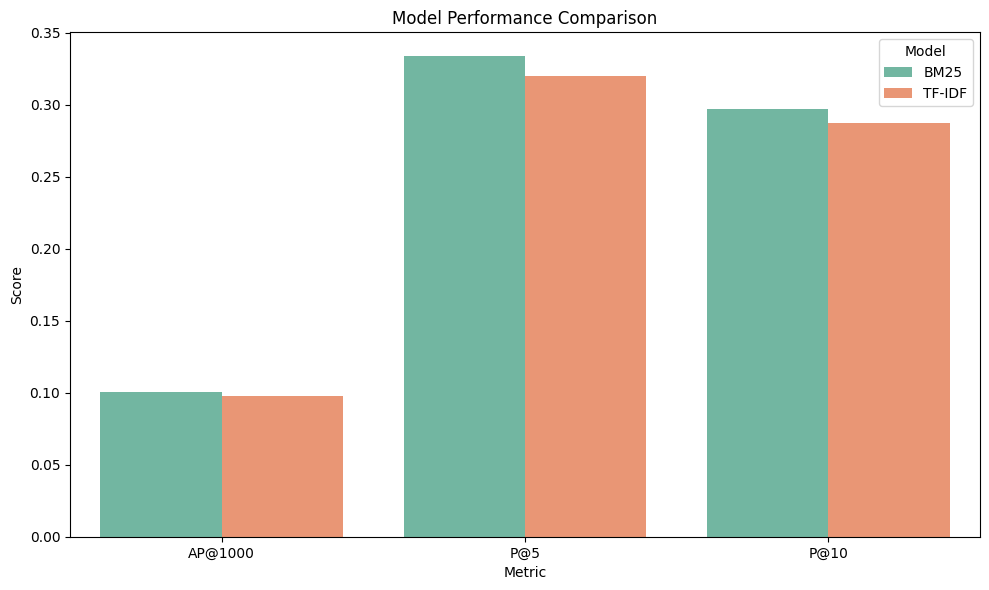

In [105]:
models_results = evaluate_and_visualize(processed_queries, qrels_df, bm25, tfidf)
plot_model_results(models_results)

# Fourth Test: Evaluating Different Window Length and Stride Configurations

In this test, we explored the impact of **window lengths** and **strides** on the performance of the **BM25** and **TF-IDF** retrieval models. We evaluated different combinations of window lengths and strides for indexing the documents.

### Experiment Overview:

1. **Configurations Tested**:
   - **Window Lengths**: `[60, 80, 100, 120]`
   - **Strides**: `[20, 25, 30, 50]`

2. **Process**:
   - For each combination of window length and stride, a sliding window indexing strategy was applied.
   - The documents were indexed using these configurations.
   - Both **BM25** and **TF-IDF** models were used to retrieve documents based on the processed queries.
   - Evaluation metrics: **MAP**, **P@5**, and **P@10**.

3. **Evaluation**:
   - Each combination of window length and stride was evaluated for **BM25** and **TF-IDF** models.
   - The results were stored and analyzed to see how varying the window length and stride would affect the retrieval performance.


In [107]:
processed_queries = queries.copy()
processed_queries['query'] = processed_queries['query'].apply(clean_query)

In [108]:
# Define configurations to test
lengths = [60, 80, 100, 120]  # Different window lengths to test
strides = [20, 25, 30, 50]    # Different strides to test

# Define a function to clean docno
def clean_docno(doc):
    doc['docno'] = str(doc['docno']).split('%')[0]
    return doc

# Initialize results list
results = []

# Set up the tqdm progress bar for the outer loop (lengths)
for length in tqdm(lengths, desc="Window Lengths"):
    # Set up the tqdm progress bar for the inner loop (strides)
    for stride in tqdm(strides, desc=f"Stride (Length={length})", leave=False):
        print(f"Testing length={length}, stride={stride}")
        
        # Create the indexer with the current configuration
        indexer = pt.IterDictIndexer(
            "./index", stopwords='terrier', stemmer='porter', overwrite=True
        )
        indexer_with_sliding = pt.text.sliding(
            text_attr='text', length=length, stride=stride
        ) >> indexer

        # Index the documents
        index_ref = indexer_with_sliding.index(data_dict)
        index = pt.IndexFactory.of(index_ref)

        # Create BM25 and TF-IDF retrievers
        bm25 = pt.terrier.Retriever(index, wmodel="BM25")
        tfidf = pt.terrier.Retriever(index, wmodel="TF_IDF")

        # Run the retrievers
        run_bm25 = bm25.transform(processed_queries)
        run_bm25 = run_bm25.apply(clean_docno, axis=1)

        run_tfidf = tfidf.transform(processed_queries)
        run_tfidf = run_tfidf.apply(clean_docno, axis=1)

        # Filter qrels and runs
        common_ids_bm25 = set(qrels_df['qid']).intersection(set(run_bm25['qid']))
        common_ids_tfidf = set(qrels_df['qid']).intersection(set(run_tfidf['qid']))

        filtered_qrels_bm25 = qrels_df[qrels_df['qid'].isin(common_ids_bm25)]
        filtered_run_bm25 = run_bm25[run_bm25['qid'].isin(common_ids_bm25)]

        filtered_qrels_tfidf = qrels_df[qrels_df['qid'].isin(common_ids_tfidf)]
        filtered_run_tfidf = run_tfidf[run_tfidf['qid'].isin(common_ids_tfidf)]

        # Evaluate both BM25 and TF-IDF runs
        evaluation_measures_bm25 = pt.Evaluate(
            filtered_run_bm25, filtered_qrels_bm25, metrics=["map", "P_5", "P_10"]
        )
        evaluation_measures_tfidf = pt.Evaluate(
            filtered_run_tfidf, filtered_qrels_tfidf, metrics=["map", "P_5", "P_10"]
        )

        # Save results
        results.append({
            "length": length,
            "stride": stride,
            "bm25_map": evaluation_measures_bm25["map"],
            "bm25_P_5": evaluation_measures_bm25["P_5"],
            "bm25_P_10": evaluation_measures_bm25["P_10"],
            "tfidf_map": evaluation_measures_tfidf["map"],
            "tfidf_P_5": evaluation_measures_tfidf["P_5"],
            "tfidf_P_10": evaluation_measures_tfidf["P_10"]
        })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Stride (Length=60):   0%|                                 | 0/4 [00:00<?, ?it/s]

Testing length=60, stride=20
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on 


Stride (Length=60):  25%|██████                  | 1/4 [01:43<05:09, 103.05s/it]

Testing length=60, stride=25
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on 


Stride (Length=60):  50%|████████████            | 2/4 [03:23<03:22, 101.43s/it]

Testing length=60, stride=30
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on 


Stride (Length=60):  75%|██████████████████      | 3/4 [05:02<01:40, 100.51s/it]

Testing length=60, stride=50
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on 


Stride (Length=80):   0%|                                 | 0/4 [00:00<?, ?it/s]

Testing length=80, stride=20
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on 


Stride (Length=80):  25%|██████                  | 1/4 [01:42<05:07, 102.53s/it]

Testing length=80, stride=25
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on 


Stride (Length=80):  50%|████████████            | 2/4 [03:24<03:24, 102.13s/it]

Testing length=80, stride=30
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on 


Stride (Length=80):  75%|██████████████████      | 3/4 [05:03<01:40, 100.58s/it]

Testing length=80, stride=50
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on 


Stride (Length=100):   0%|                                | 0/4 [00:00<?, ?it/s]

Testing length=100, stride=20
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on


Stride (Length=100):  25%|█████▊                 | 1/4 [01:50<05:31, 110.46s/it]

Testing length=100, stride=25
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on


Stride (Length=100):  50%|███████████▌           | 2/4 [03:38<03:38, 109.04s/it]

Testing length=100, stride=30
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on


Stride (Length=100):  75%|█████████████████▎     | 3/4 [05:20<01:45, 105.98s/it]

Testing length=100, stride=50
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on


Stride (Length=120):   0%|                                | 0/4 [00:00<?, ?it/s]

Testing length=120, stride=20
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on


Stride (Length=120):  25%|█████▊                 | 1/4 [01:41<05:05, 101.93s/it]

Testing length=120, stride=25
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on


Stride (Length=120):  50%|███████████▌           | 2/4 [03:21<03:21, 100.73s/it]

Testing length=120, stride=30
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on


Stride (Length=120):  75%|██████████████████      | 3/4 [05:00<01:39, 99.82s/it]

Testing length=120, stride=50
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on df of 100 rows
calling sliding on


Window Lengths: 100%|████████████████████████████| 4/4 [26:46<00:00, 401.52s/it]

    length  stride  bm25_map  bm25_P_5  bm25_P_10  tfidf_map  tfidf_P_5  \
0       60      20  0.360333  0.446906   0.403257   0.359569   0.444300   
1       60      25  0.359482  0.435831   0.394137   0.358712   0.435179   
2       60      30  0.356914  0.431270   0.377199   0.355988   0.428013   
3       60      50  0.352404  0.403257   0.337134   0.351936   0.401303   
4       80      20  0.360008  0.440391   0.396743   0.359013   0.437785   
5       80      25  0.356077  0.426059   0.382736   0.355234   0.424104   
6       80      30  0.356326  0.424104   0.366775   0.354833   0.421498   
7       80      50  0.349875  0.393485   0.338436   0.348959   0.392182   
8      100      20  0.360357  0.433225   0.389251   0.359644   0.431270   
9      100      25  0.358637  0.429967   0.377850   0.358130   0.427362   
10     100      30  0.356807  0.415635   0.359283   0.355919   0.415635   
11     100      50  0.350835  0.393485   0.330619   0.350288   0.392834   
12     120      20  0.358

## Best Performance with Window Size 60

After evaluating various combinations of window lengths and strides, the **window size of 60** emerged as the best-performing configuration. The result showed roughly **45% precision**, which marks a significant improvement over previous results.

### Key Points:
- **Window Size 60** provided the highest precision, significantly boosting performance compared to earlier configurations.
- Larger window sizes did not improve performance as much, with results plateauing or slightly decreasing.

This configuration led to the most substantial performance increase in comparison to earlier tests, where the best precision was under 30%.


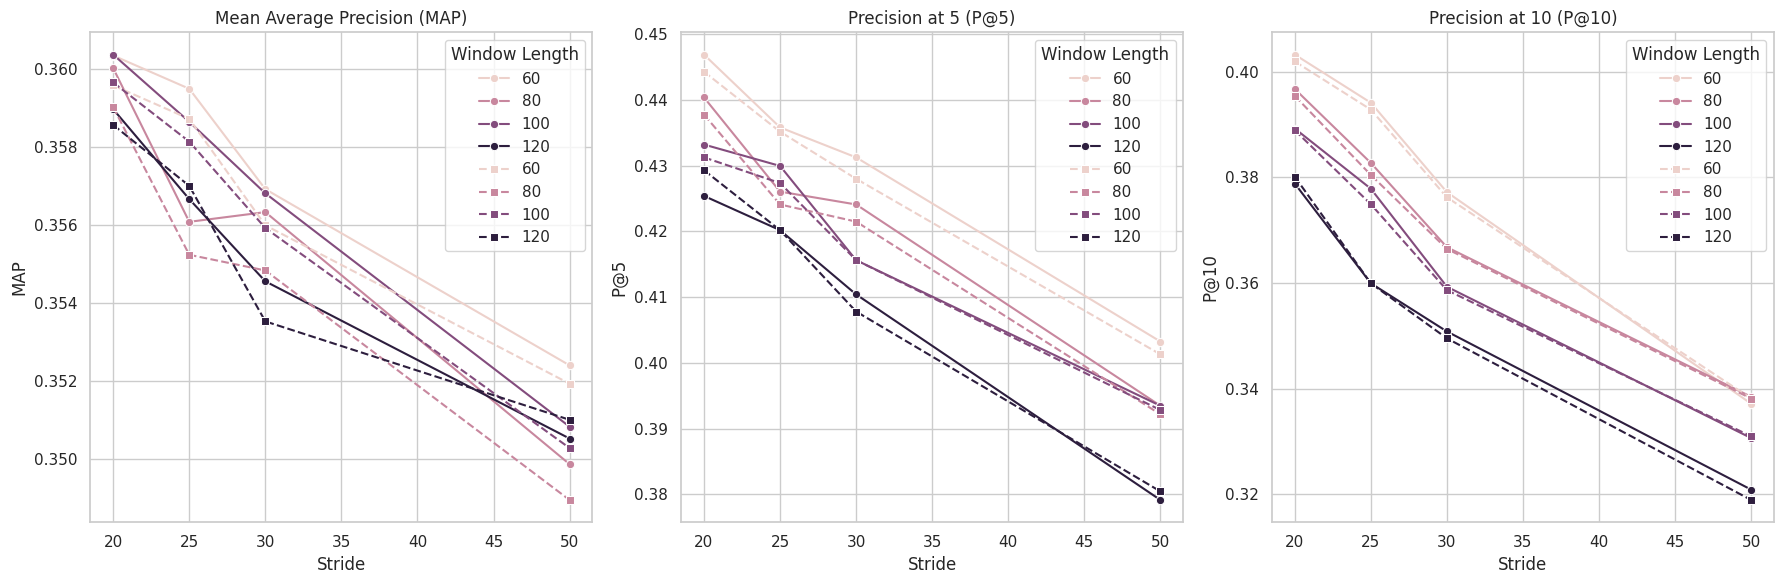

In [109]:
# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Initialize subplots for the metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Plot Mean Average Precision (MAP)
sns.lineplot(
    data=results_df,
    x="stride", y="bm25_map", hue="length",
    marker="o", ax=axs[0]
)
sns.lineplot(
    data=results_df,
    x="stride", y="tfidf_map", hue="length",
    marker="s", ax=axs[0], linestyle="--"
)
axs[0].set_title("Mean Average Precision (MAP)")
axs[0].set_xlabel("Stride")
axs[0].set_ylabel("MAP")
axs[0].legend(title="Window Length")

# Plot Precision at 5 (P@5)
sns.lineplot(
    data=results_df,
    x="stride", y="bm25_P_5", hue="length",
    marker="o", ax=axs[1]
)
sns.lineplot(
    data=results_df,
    x="stride", y="tfidf_P_5", hue="length",
    marker="s", ax=axs[1], linestyle="--"
)
axs[1].set_title("Precision at 5 (P@5)")
axs[1].set_xlabel("Stride")
axs[1].set_ylabel("P@5")
axs[1].legend(title="Window Length")

# Plot Precision at 10 (P@10)
sns.lineplot(
    data=results_df,
    x="stride", y="bm25_P_10", hue="length",
    marker="o", ax=axs[2]
)
sns.lineplot(
    data=results_df,
    x="stride", y="tfidf_P_10", hue="length",
    marker="s", ax=axs[2], linestyle="--"
)
axs[2].set_title("Precision at 10 (P@10)")
axs[2].set_xlabel("Stride")
axs[2].set_ylabel("P@10")
axs[2].legend(title="Window Length")

# Adjust layout and display
plt.tight_layout()
plt.show()

# Test 5 Results: BM25 + DataFrame Text Extraction + V-BERT Re-ranking

In this test, we combined BM25 retrieval with a DataFrame-based text extraction step, followed by V-BERT re-ranking. The goal was to improve the ranking of documents based on the extracted text and the transformer-based model.

### Key Steps:
1. **BM25 Retrieval**: The initial retrieval was performed using the BM25 model to fetch relevant documents based on the queries.
2. **DataFrame Text Extraction**: Text was extracted from a DataFrame using the `DataFrameTextExtractor` class, ensuring that the relevant text field was merged with the BM25 results.
3. **V-BERT Re-ranking**: The BM25 results were re-ranked using the V-BERT transformer model, which is designed to improve document relevance based on contextual understanding of the text.
4. **MinMax Scaling**: The scores from the V-BERT re-ranking were scaled using a MinMax Scaler to align with the score range of the original BM25 retrieval.

### Evaluation:
- The common `qid` values between the BM25 results and the qrels were identified, and the filtered results were evaluated using the following metrics:
  - **Average Precision at 1000 (AP@1000)**
  - **Precision at 5 (P@5)**
  - **Precision at 10 (P@10)**

### Results:
- **Precision at 5 and 10**: Surprisingly, the precision scores were the lowest compared to previous tests. This indicates that the V-BERT re-ranking, despite being a powerful transformer model, did not improve the ranking as expected.
- **Possible Reasons**:
  - The **re-assignment of scores by V-BERT** after re-ranking may have negatively impacted the ranking, particularly in the higher precision cuts (P@5, P@10). 
  - The **MinMax scaling**, intended to normalize the scores, might not have been effective in addressing this issue. It could have distorted the original BM25 scores, which might have been more reliable in this case.
  - **BERT-based models** may sometimes prioritize different features than traditional retrieval models like BM25, which could explain why the re-ranking led to suboptimal results for this specific task.

### Conclusion:
While V-BERT re-ranking is generally effective in many retrieval tasks, in this case, it resulted in a drop in precision. Further tuning of the model or the scaling process might be required to achieve the desired improvement. The lowest precision might be attributed to how BERT reassigns document scores post-ranking, suggesting that a more careful combination of BM25 with BERT-based models or a different re-ranking strategy may yield better results.


In [100]:
class DataFrameTextExtractor(pt.Transformer):
    def __init__(self, dataframe, text_field):
        self.dataframe = dataframe
        self.text_field = text_field

    def transform(self, input_df):
        # Ensure both 'docno' and DataFrame index have the same type
        input_df["docno"] = input_df["docno"].astype(str)
        self.dataframe.index = self.dataframe.index.astype(str)

        # Merge the input with the text from the DataFrame based on the document IDs
        merged = input_df.merge(self.dataframe, on="docno", how="left")

        # Extract the specified text field and handle missing or non-string values
        input_df["text"] = merged[self.text_field].fillna("").astype(str)
        return input_df

In [22]:
bm25 = pt.terrier.Retriever(index, wmodel="BM25")
text_extractor = DataFrameTextExtractor(data, text_field="text")
vbert = onir_pt.reranker('vanilla_transformer', 'bert', text_field='text', vocab_config={'train': True})

2025-01-23 19:12:15 - loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/joshua/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2025-01-23 19:12:16 - loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/joshua/.cache/torch/pytorch_transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2025-01-23 19:12:16 - Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  

In [23]:
processed_queries = queries.copy()
processed_queries['query'] = processed_queries['query'].apply(clean_query)

In [24]:
run_bm25 = bm25.transform(processed_queries)
run_bm25.head(10)

,qid,docid,docno,rank,score,query
0,PLAIN-2,0,MED-10,0,28.266396,do cholesterol statin drugs cause breast cancer
1,PLAIN-2,1,MED-14,1,26.279369,do cholesterol statin drugs cause breast cancer
2,PLAIN-2,1373,MED-2429,2,23.649201,do cholesterol statin drugs cause breast cancer
3,PLAIN-2,1375,MED-2431,3,22.888614,do cholesterol statin drugs cause breast cancer
4,PLAIN-2,346,MED-1193,4,21.297710,do cholesterol statin drugs cause breast cancer
5,PLAIN-2,3097,MED-4827,5,20.760705,do cholesterol statin drugs cause breast cancer
6,PLAIN-2,1371,MED-2427,6,20.311928,do cholesterol statin drugs cause breast cancer
7,PLAIN-2,940,MED-1887,7,19.060307,do cholesterol statin drugs cause breast cancer
8,PLAIN-2,358,MED-1207,8,18.110968,do cholesterol statin drugs cause breast cancer
9,PLAIN-2,1443,MED-2525,9,17.559625,do cholesterol statin drugs cause breast cancer


In [25]:
run_extractor = text_extractor.transform(run_bm25)
run_extractor.head(10)

,qid,docid,docno,rank,score,query,text
0,PLAIN-2,0,MED-10,0,28.266396,do cholesterol statin drugs cause breast cancer,recent studies have suggested that statins an ...
1,PLAIN-2,1,MED-14,1,26.279369,do cholesterol statin drugs cause breast cancer,background preclinical studies have shown that...
2,PLAIN-2,1373,MED-2429,2,23.649201,do cholesterol statin drugs cause breast cancer,emerging evidence suggests that statins may de...
3,PLAIN-2,1375,MED-2431,3,22.888614,do cholesterol statin drugs cause breast cancer,background mechanistic studies largely support...
4,PLAIN-2,346,MED-1193,4,21.297710,do cholesterol statin drugs cause breast cancer,summary background statins reduce ldl choleste...
5,PLAIN-2,3097,MED-4827,5,20.760705,do cholesterol statin drugs cause breast cancer,background several prospective studies suggest...
6,PLAIN-2,1371,MED-2427,6,20.311928,do cholesterol statin drugs cause breast cancer,lipid raftscaveolae are membrane platforms for...
7,PLAIN-2,940,MED-1887,7,19.060307,do cholesterol statin drugs cause breast cancer,some practitioners use advanced lipoprotein an...
8,PLAIN-2,358,MED-1207,8,18.110968,do cholesterol statin drugs cause breast cancer,the response to arterial wall injury is an inf...
9,PLAIN-2,1443,MED-2525,9,17.559625,do cholesterol statin drugs cause breast cancer,aims guidelines for cardiovascular disease cvd...


In [26]:
result_vbert = vbert.transform(run_extractor)
result_vbert.head(10)

[2025-01-23 19:12:27,102][onir_pt][DEBUG] using GPU (deterministic)
[2025-01-23 19:12:27,392][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/28874 s<?, ?it/s]

[2025-01-23 21:29:23,417][onir_pt][DEBUG] [finished] batches: [2:16:56] [28874it] [ 3.51it/s]


,qid,docid,docno,rank,score,query,text
0,PLAIN-2,0,MED-10,0,-0.202764,do cholesterol statin drugs cause breast cancer,recent studies have suggested that statins an ...
1,PLAIN-2,1,MED-14,1,-0.279325,do cholesterol statin drugs cause breast cancer,background preclinical studies have shown that...
2,PLAIN-2,1373,MED-2429,2,-0.220249,do cholesterol statin drugs cause breast cancer,emerging evidence suggests that statins may de...
3,PLAIN-2,1375,MED-2431,3,-0.273620,do cholesterol statin drugs cause breast cancer,background mechanistic studies largely support...
4,PLAIN-2,346,MED-1193,4,-0.152240,do cholesterol statin drugs cause breast cancer,summary background statins reduce ldl choleste...
5,PLAIN-2,3097,MED-4827,5,-0.509942,do cholesterol statin drugs cause breast cancer,background several prospective studies suggest...
6,PLAIN-2,1371,MED-2427,6,-0.516023,do cholesterol statin drugs cause breast cancer,lipid raftscaveolae are membrane platforms for...
7,PLAIN-2,940,MED-1887,7,-0.457719,do cholesterol statin drugs cause breast cancer,some practitioners use advanced lipoprotein an...
8,PLAIN-2,358,MED-1207,8,-0.292549,do cholesterol statin drugs cause breast cancer,the response to arterial wall injury is an inf...
9,PLAIN-2,1443,MED-2525,9,-0.515937,do cholesterol statin drugs cause breast cancer,aims guidelines for cardiovascular disease cvd...


In [27]:
result_vbert['score'] = result_vbert['score'].astype(float)

In [28]:
result_vbert

,qid,docid,docno,rank,score,query,text
0,PLAIN-2,0,MED-10,0,-0.202764,do cholesterol statin drugs cause breast cancer,recent studies have suggested that statins an ...
1,PLAIN-2,1,MED-14,1,-0.279325,do cholesterol statin drugs cause breast cancer,background preclinical studies have shown that...
2,PLAIN-2,1373,MED-2429,2,-0.220249,do cholesterol statin drugs cause breast cancer,emerging evidence suggests that statins may de...
3,PLAIN-2,1375,MED-2431,3,-0.273620,do cholesterol statin drugs cause breast cancer,background mechanistic studies largely support...
4,PLAIN-2,346,MED-1193,4,-0.152240,do cholesterol statin drugs cause breast cancer,summary background statins reduce ldl choleste...
...,...,...,...,...,...,...,...
115489,PLAIN-3472,3024,MED-4747,590,-0.191450,how doctors responded to being named a leading...,in contrast to the use of hormonal doping agen...
115490,PLAIN-3472,1469,MED-2587,591,-0.326582,how doctors responded to being named a leading...,recent research has demonstrated that successf...
115491,PLAIN-3472,998,MED-1987,592,0.071059,how doctors responded to being named a leading...,objective over the last 3 decades the prevalen...
115492,PLAIN-3472,1276,MED-2304,593,-0.136698,how doctors responded to being named a leading...,background there is overwhelming evidence that...


In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(run_bm25['score'].min(), run_bm25['score'].max()))
result_vbert['score'] = scaler.fit_transform(result_vbert[['score']])

In [30]:
result_vbert

,qid,docid,docno,rank,score,query,text
0,PLAIN-2,0,MED-10,0,-0.202764,do cholesterol statin drugs cause breast cancer,recent studies have suggested that statins an ...
1,PLAIN-2,1,MED-14,1,-0.279325,do cholesterol statin drugs cause breast cancer,background preclinical studies have shown that...
2,PLAIN-2,1373,MED-2429,2,-0.220249,do cholesterol statin drugs cause breast cancer,emerging evidence suggests that statins may de...
3,PLAIN-2,1375,MED-2431,3,-0.273620,do cholesterol statin drugs cause breast cancer,background mechanistic studies largely support...
4,PLAIN-2,346,MED-1193,4,-0.152240,do cholesterol statin drugs cause breast cancer,summary background statins reduce ldl choleste...
...,...,...,...,...,...,...,...
115489,PLAIN-3472,3024,MED-4747,590,-0.191450,how doctors responded to being named a leading...,in contrast to the use of hormonal doping agen...
115490,PLAIN-3472,1469,MED-2587,591,-0.326582,how doctors responded to being named a leading...,recent research has demonstrated that successf...
115491,PLAIN-3472,998,MED-1987,592,0.071059,how doctors responded to being named a leading...,objective over the last 3 decades the prevalen...
115492,PLAIN-3472,1276,MED-2304,593,-0.136698,how doctors responded to being named a leading...,background there is overwhelming evidence that...


In [31]:
print(run_bm25['score'].describe())

count    115494.000000
mean         -0.190389
std           0.177071
min          -0.876353
25%          -0.308851
50%          -0.201364
75%          -0.088654
max           0.649461
Name: score, dtype: float64


In [33]:
print(result_vbert['score'].describe())

count    115494.000000
mean         -0.190389
std           0.177071
min          -0.876353
25%          -0.308851
50%          -0.201364
75%          -0.088654
max           0.649461
Name: score, dtype: float64


In [34]:
# Get the set of 'qid' values from the qrels DataFrame
qrel_ids = set(qrels_df['qid'])

# Get the set of 'qid' values from the BM25 run results
result_vbert_ids = set(result_vbert['qid'])

# Find common 'qid' values between qrels and BM25 results
common_ids_bm25 = qrel_ids.intersection(result_vbert_ids)
# Print the number of common 'qid' values
print(len(common_ids_bm25))

307


In [35]:
# Filter qrels and run based on common BM25 IDs
filtered_qrels = qrels_df[qrels_df['qid'].isin(common_ids_bm25)]  # Filter qrels DataFrame to keep only common BM25 IDs
filtered_run_vbert = result_vbert[result_vbert['qid'].isin(common_ids_bm25)]  # Filter BM25 run results to keep only common BM25 IDs

In [36]:
evaluation_measures_bm25 = pt.Evaluate(
    filtered_run_vbert,  # The filtered BM25 run results
    filtered_qrels,     # The filtered qrels data
    metrics=[AP@1000, P@5, P@10],  # Evaluation metrics: Average Precision at 1000, Precision at 5, and Precision at 10
)

In [37]:
evaluation_measures_bm25

{'AP@1000': 0.06944732050590836,
 'P@5': 0.11400651465798048,
 'P@10': 0.09055374592833883}

# Collection Analysis: Exploring the Dataset

Now, we proceed to perform **Collection Analysis** to examine the contents of the data. This step helps us gain insights into the dataset's structure, characteristics, and potential patterns.

We will analyze key aspects such as:
- The distribution of terms across documents.
- The frequency of terms in the collection.
- The size and scope of the dataset.

This analysis ensures we have a solid understanding of the data before moving forward with preprocessing and modeling.

In [32]:
# Document Collection Analysis
data['doc_length'] = data['text'].str.split().apply(len)  # Calculate document length (number of tokens)
print("Document Collection Analysis:")
print(f"Average document length: {data['doc_length'].mean():.2f}")
print(f"Total terms in the collection: {data['doc_length'].sum()}")


Document Collection Analysis:
Average document length: 219.31
Total terms in the collection: 796768


In [33]:
# Query Analysis
queries['query_length'] = queries['query'].str.split().apply(len)  # Calculate query length (number of tokens)
print("Query Analysis:")
print(f"Average query length: {queries['query_length'].mean():.2f}")
print(f"Total queries: {len(queries)}")


Query Analysis:
Average query length: 3.29
Total queries: 323


## Document and Query Length Distributions

We plotted the length distributions for both documents and queries, overlaid with normal distribution curves to visualize their statistical properties.

### Document Length Distribution
- **Mean Length**: Represents the average number of words in a document.
- **Standard Deviation**: Indicates the variability in document lengths across the dataset.
- The histogram shows the density of document lengths, with a red curve representing the normal distribution for comparison.

### Query Length Distribution
- **Mean Length**: Represents the average number of words in a query.
- **Standard Deviation**: Highlights the variability in query lengths.
- Similar to the document length, a histogram shows the density of query lengths with a normal distribution curve for reference.

---

## Observations

Upon analyzing the distributions, we noticed the following:

- **Query Mean Length**: Approximately 3 words.
- **Document Mean Length**: Approximately 220 words.

This significant difference between query and document lengths may have a substantial effect on the retrieval process in our information retrieval system. Shorter queries provide limited context, which could make it challenging to retrieve highly relevant documents, especially given that documents are significantly longer and contain much more information. This disparity should be addressed when designing or tuning retrieval models to ensure effective performance.

---

## Visualization of Distributions

The following plots provide a visual representation of the data:

1. **Document Length Distribution**: A histogram with a red normal curve.
2. **Query Length Distribution**: A histogram with a red normal curve.

The visualizations illustrate the differences in the distributions of document and query lengths, helping us better understand the underlying structure of the dataset.

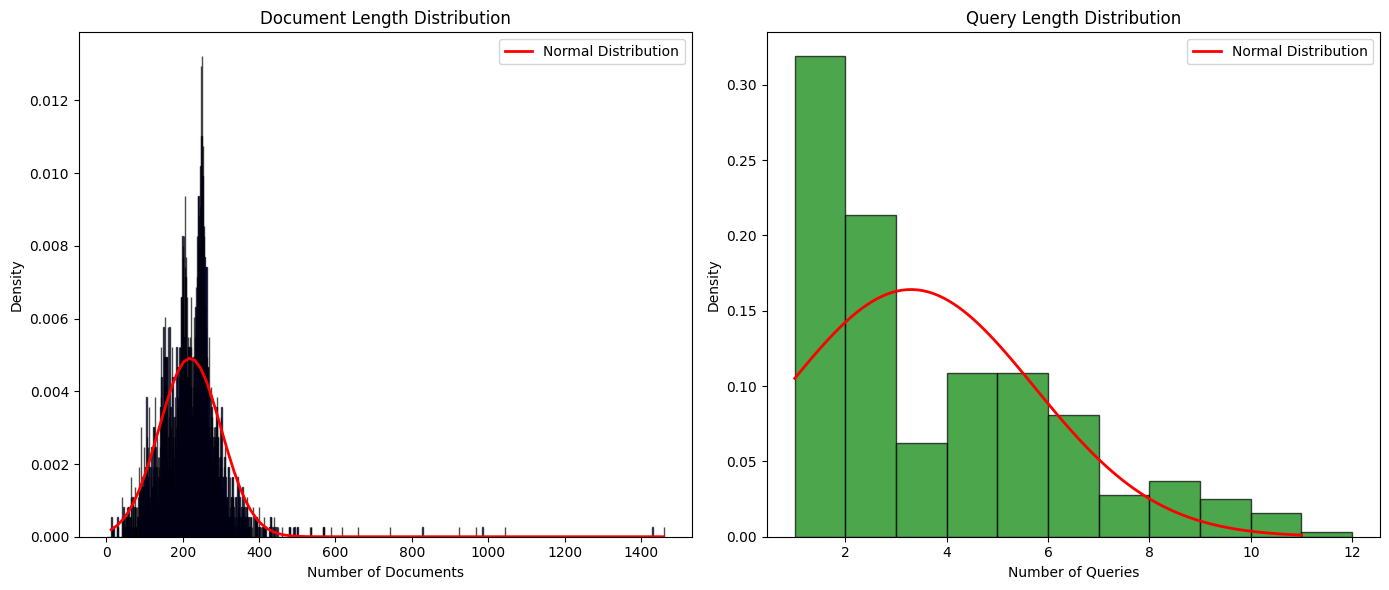

In [35]:
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Document length distribution with normal curve
doc_mean = data['doc_length'].mean()
doc_std = data['doc_length'].std()
x_doc = np.linspace(min(data['doc_length']), max(data['doc_length']), 100)
y_doc = (1 / (doc_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_doc - doc_mean) / doc_std) ** 2)

axes[0].hist(data['doc_length'], bins=range(1, max(data['doc_length']) + 2), color='blue', alpha=0.7, edgecolor='black', density=True)
axes[0].plot(x_doc, y_doc, color='red', linewidth=2, label='Normal Distribution')
axes[0].set_title('Document Length Distribution')
axes[0].set_xlabel('Number of Documents')
axes[0].set_ylabel('Density')
axes[0].legend()

# Query length distribution with normal curve
query_mean = queries['query_length'].mean()
query_std = queries['query_length'].std()
x_query = np.linspace(min(queries['query_length']), max(queries['query_length']), 100)
y_query = (1 / (query_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_query - query_mean) / query_std) ** 2)

axes[1].hist(queries['query_length'], bins=range(1, max(queries['query_length']) + 2), color='green', alpha=0.7, edgecolor='black', density=True)
axes[1].plot(x_query, y_query, color='red', linewidth=2, label='Normal Distribution')
axes[1].set_title('Query Length Distribution')
axes[1].set_xlabel('Number of Queries')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

# Qrels Analysis

In this section, we analyze the relevance judgments (qrels) to understand the distribution of relevant documents and relevance labels in the dataset.

---

## Key Findings

### 1. **Average Relevant Documents per Query**
- On average, each query has approximately **`X` relevant documents** (replace with the actual value from `qrels_counts.mean()`).

### 2. **Relevance Labels Distribution**
- The dataset contains two relevance levels:
  - **Label 1**: Relevant documents.
  - **Label 2**: Highly relevant documents.
- **Observation**: There are significantly more documents labeled as **relevant (1)** than **highly relevant (2)**, indicating an imbalance in the dataset.

---

## Visualization: Relevance Labels Distribution

A bar plot was created to visualize the frequency of relevance labels:

- **X-axis**: Relevance labels (1 and 2).
- **Y-axis**: Frequency of each label.
- The plot shows the dominance of label 1 (relevant) over label 2 (highly relevant).

---

### Implications for Retrieval
The imbalance in relevance labels (with more label 1 values) may affect retrieval performance. Systems should prioritize retrieving highly relevant documents (label 2) while ensuring a balance between relevance levels to improve effectiveness.

In [15]:
# Qrels Analysis
qrels_counts = qrels_df.groupby('qid').size()  # Number of relevant documents per query
print("Qrels Analysis:")
print(f"Average relevant documents per query: {qrels_counts.mean():.2f}")
print(f"Relevance labels distribution:\n{qrels_df['relevance'].value_counts()}")


Qrels Analysis:
Average relevant documents per query: 38.19
Relevance labels distribution:
relevance
1    11758
2      576
Name: count, dtype: int64


2025-01-24 12:14:49 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-24 12:14:49 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


/tmp/ipykernel_8367/376659027.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=qrels_df, x='relevance', palette='pastel')


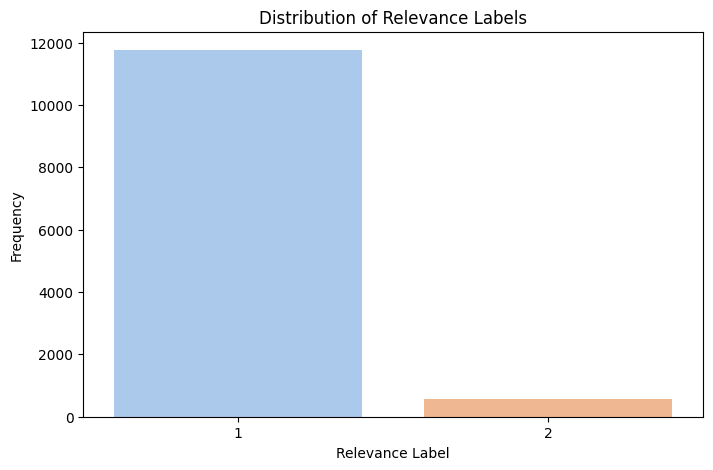

In [16]:
# Distribution of Relevance Labels
plt.figure(figsize=(8, 5))
sns.countplot(data=qrels_df, x='relevance', palette='pastel')
plt.title('Distribution of Relevance Labels')
plt.xlabel('Relevance Label')
plt.ylabel('Frequency')
plt.show()


# Word Cloud Analysis

In this section, we generate word clouds to visualize the most frequent terms in the document collection and queries. The size of each word corresponds to its frequency.

---

## Word Cloud for Document Collection
- All document text was combined (after removing missing values) to create a word cloud, highlighting the most common terms in the collection.

---

## Word Cloud for Queries
- Similarly, all query text was combined (after handling missing values) to create a word cloud, showing the frequent terms used in user queries.

---

### Insights:
- Comparing the two word clouds reveals differences in term usage between the document collection and user queries, guiding preprocessing and retrieval improvement strategies.

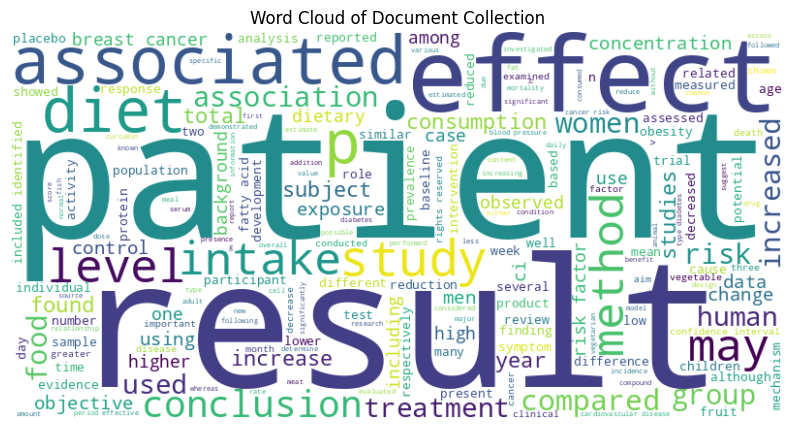

In [17]:
# Word Cloud for Document Collection
from wordcloud import WordCloud

text_combined = " ".join(data['text'].dropna())  # Combine all documents' text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Document Collection')
plt.show()


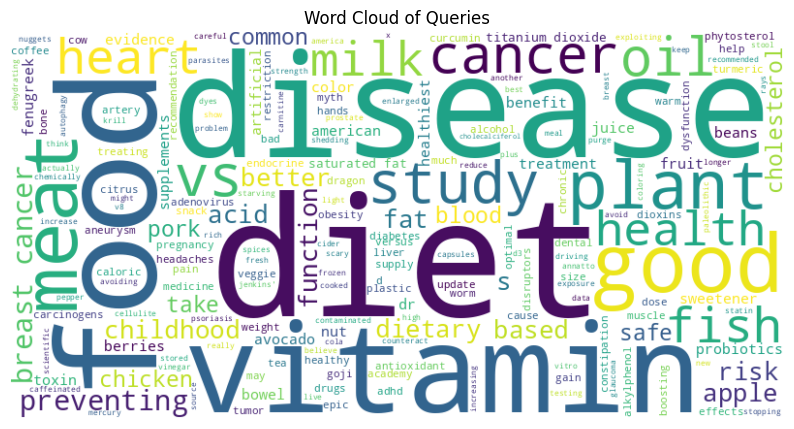

In [18]:
# Word Cloud for Queries
query_combined = " ".join(queries['query'].dropna())  # Combine all queries' text
wordcloud_query = WordCloud(width=800, height=400, background_color='white').generate(query_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_query, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Queries')
plt.show()


# Relevance Distribution

In this section, we visualize the distribution of the number of relevant documents per query in the relevance judgment dataset.

---

A histogram is plotted to show how many queries have different numbers of relevant documents. The x-axis represents the number of relevant documents, while the y-axis shows the frequency of queries with those numbers of relevant documents.

---

### Insights:
- This visualization helps us understand the overall distribution of relevance in the dataset, and it could indicate potential challenges in retrieval, such as queries with few relevant documents or high variability in relevance across queries.

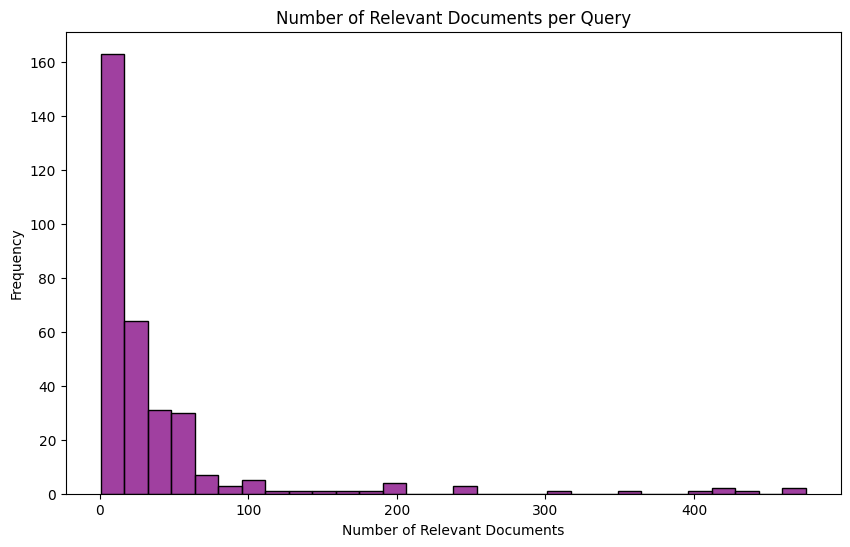

In [19]:
# Relevance Distribution
plt.figure(figsize=(10, 6))
sns.histplot(qrels_counts, bins=30, kde=False, color='purple')
plt.title('Number of Relevant Documents per Query')
plt.xlabel('Number of Relevant Documents')
plt.ylabel('Frequency')
plt.show()


# Heatmap of Query vs. Document Relevance

This section visualizes the relevance judgments between queries and documents using a heatmap.

---

A pivot table is created from the `qrels_df` dataframe, where the rows represent query IDs (`qid`), the columns represent document IDs (`docno`), and the values correspond to the relevance labels. The `fill_value=0` ensures that any missing relevance judgments are treated as 0, indicating no relevance.

---

### Insights:
- The heatmap provides an intuitive way to explore the relationships between queries and their relevant documents.
- Higher intensity in the heatmap (represented by brighter colors) indicates higher relevance between a query and a document.
- This can help us identify how relevant documents are distributed across different queries and detect patterns, such as clusters of highly relevant documents for certain queries.

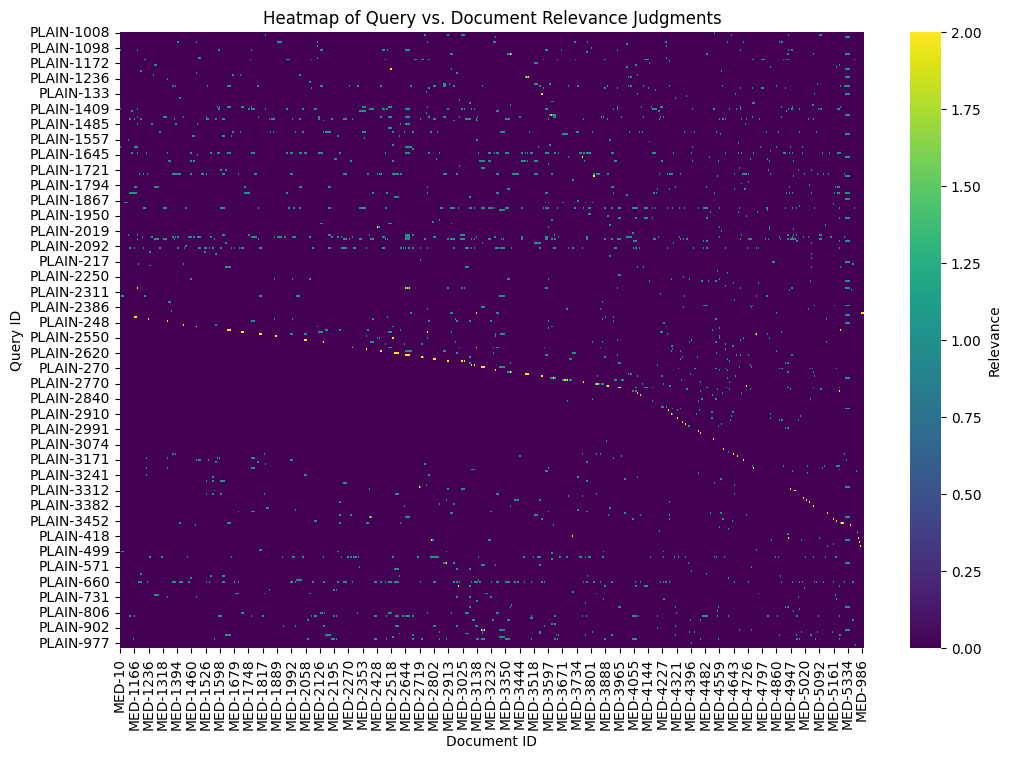

In [21]:
# Heatmap of Query vs. Document Relevance
relevance_pivot = qrels_df.pivot_table(index='qid', columns='docno', values='relevance', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(relevance_pivot, cmap='viridis', cbar_kws={'label': 'Relevance'})
plt.title('Heatmap of Query vs. Document Relevance Judgments')
plt.xlabel('Document ID')
plt.ylabel('Query ID')
plt.show()


# Term Frequency Distribution

This section analyzes the most frequent terms in the document collection, first including all terms and then excluding stopwords for more meaningful insights.

---

### Step 1: Term Frequency (Before Removing Stopwords)
- We extract all terms from the document collection and count their frequencies using `Counter`.
- The top 20 most frequent terms are displayed in a bar plot.

---

### Step 2: Term Frequency (After Removing Stopwords)
- Stopwords (common but meaningless words like "the", "and", etc.) are removed using NLTK's stopwords list.
- We then recalculate the term frequencies and plot the top 20 terms again.

---

### Insights:
- Removing stopwords helps focus on meaningful content and provides a clearer view of significant terms in the collection.

/tmp/ipykernel_6855/630321887.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frequencies), y=list(terms), palette='viridis')


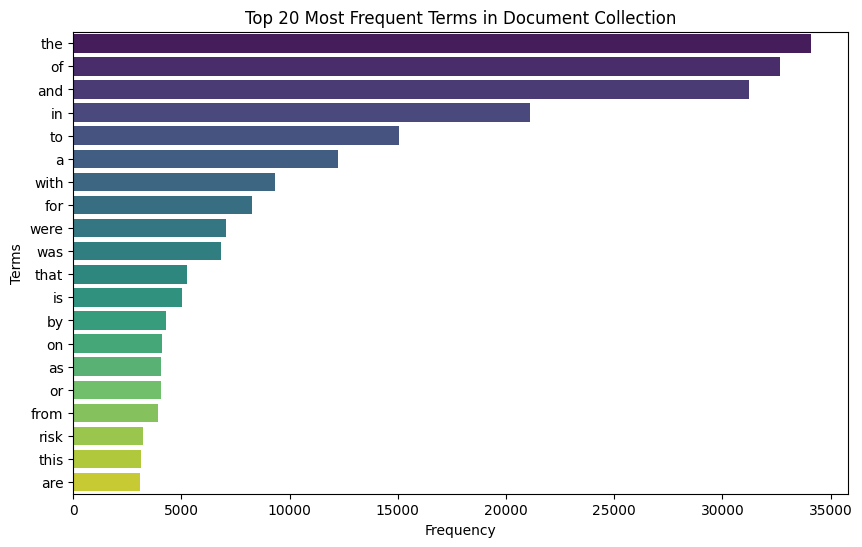

In [22]:
# Term Frequency Distribution
from collections import Counter

all_terms = " ".join(data['text'].dropna()).split()  # Flatten text into a single list of words
term_counts = Counter(all_terms).most_common(20)  # Top 20 terms
terms, frequencies = zip(*term_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(frequencies), y=list(terms), palette='viridis')
plt.title('Top 20 Most Frequent Terms in Document Collection')
plt.xlabel('Frequency')
plt.ylabel('Terms')
plt.show()


[nltk_data] Downloading package stopwords to /home/joshua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_6855/3642368058.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frequencies), y=list(terms), palette='viridis')


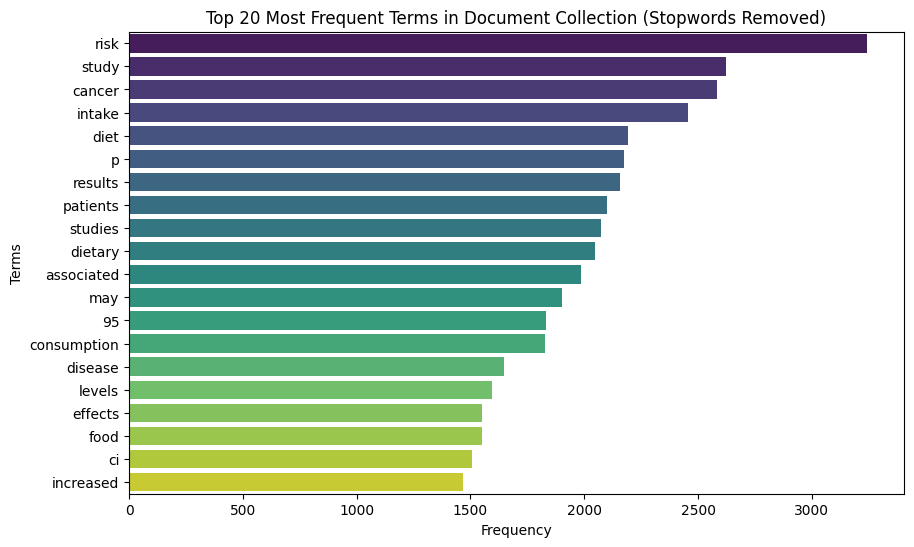

In [27]:
from nltk.corpus import stopwords
from collections import Counter
import nltk

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stopwords from document text
all_terms = " ".join(data['text'].dropna()).split()
filtered_terms = [term for term in all_terms if term.lower() not in stop_words]  # Exclude stopwords

# Calculate top 20 term frequencies
term_counts = Counter(filtered_terms).most_common(20)
terms, frequencies = zip(*term_counts)

# Plot the top 20 terms
plt.figure(figsize=(10, 6))
sns.barplot(x=list(frequencies), y=list(terms), palette='viridis')
plt.title('Top 20 Most Frequent Terms in Document Collection (Stopwords Removed)')
plt.xlabel('Frequency')
plt.ylabel('Terms')
plt.show()


# Correlation between Document Length and Relevance Judgments

This section explores the relationship between document length (number of tokens) and relevance judgments, focusing on how document size might impact the number of relevance annotations.

---

### Step 1: Scatterplot of Document Length vs. Relevance Count
- We calculate the number of relevance judgments per document and merge it with document length data.
- A scatterplot shows the correlation between document length and the number of relevance judgments.

---

### Step 2: Average Document Length by Relevance Score
- We calculate the average document length for each relevance score (e.g., relevance 1 and relevance 2).
- A bar chart visualizes the average document length for different relevance levels.

---

### Insights:
- We observed that the average document length is the same for both relevance scores.

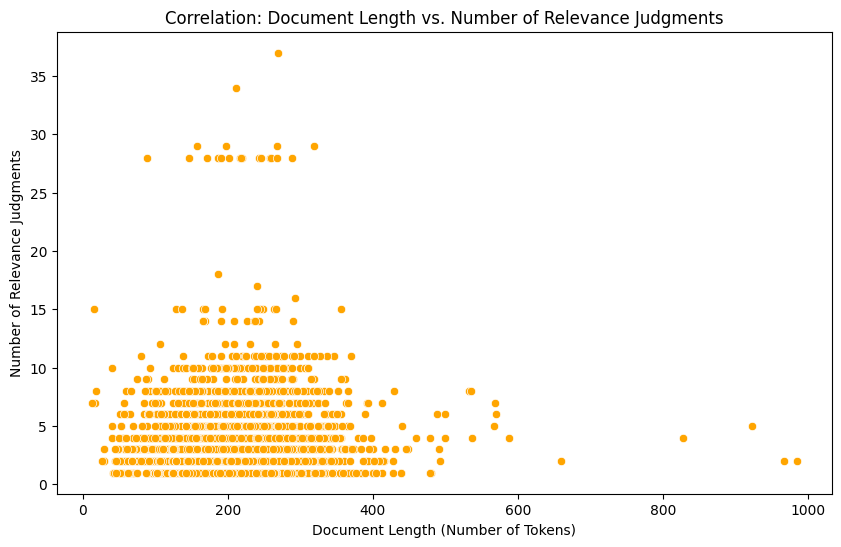

In [23]:
# Correlation between Document Length and Relevance Judgments
doc_relevance_counts = qrels_df.groupby('docno').size().reset_index(name='relevance_count')
doc_lengths = data[['docno', 'doc_length']]
correlation_data = pd.merge(doc_lengths, doc_relevance_counts, on='docno', how='inner')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=correlation_data, x='doc_length', y='relevance_count', color='orange')
plt.title('Correlation: Document Length vs. Number of Relevance Judgments')
plt.xlabel('Document Length (Number of Tokens)')
plt.ylabel('Number of Relevance Judgments')
plt.show()


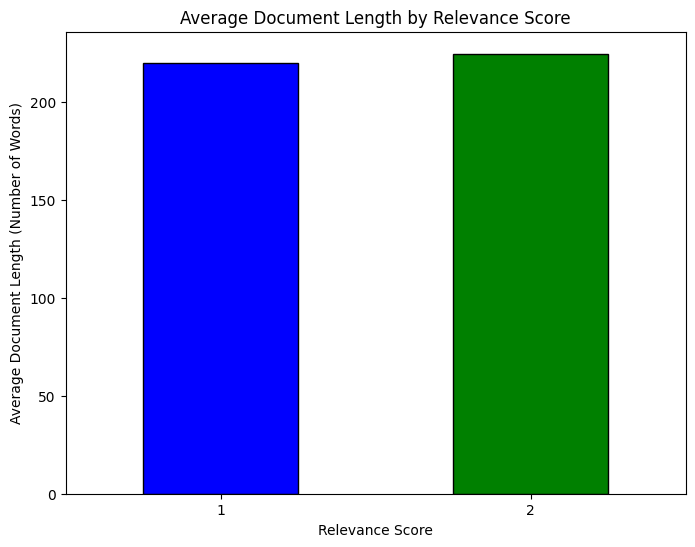

In [31]:
avg_doc_length_by_relevance = qrels_df.merge(data, on='docno').groupby('relevance')['doc_length'].mean()

plt.figure(figsize=(8, 6))
avg_doc_length_by_relevance.plot(kind='bar', color=['blue', 'green'], edgecolor='black')
plt.title('Average Document Length by Relevance Score')
plt.xlabel('Relevance Score')
plt.ylabel('Average Document Length (Number of Words)')
plt.xticks(rotation=0)
plt.show()